# Lectura y análisis de los datos





In [2]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import IPython.display as ipd
import soundfile as sf

## Observar características del audio

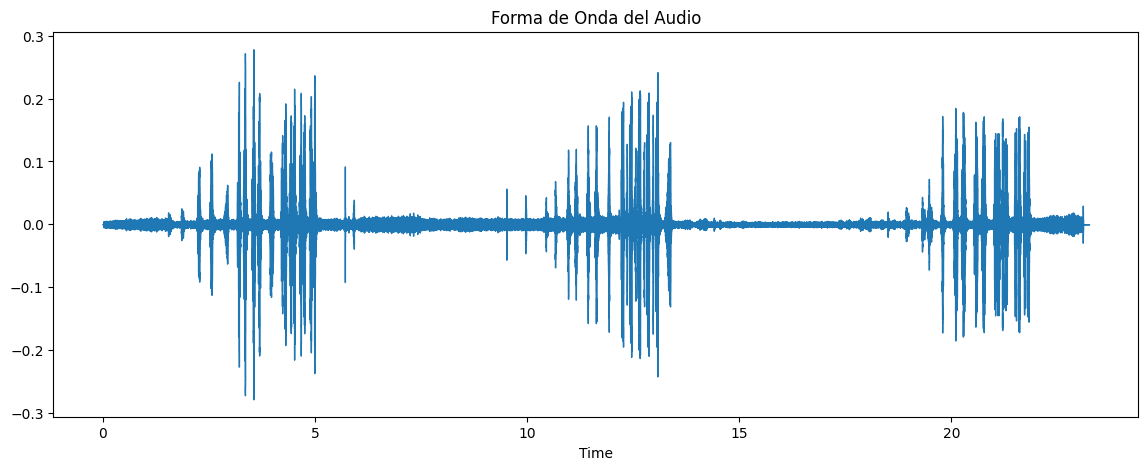

In [ ]:
# Cargar el archivo de audio MP3
mp3_path = '/content/drive/MyDrive/BigData/DataMining/Practica1/Audiofiles/Acrocephalus arundinaceus/XC417157.mp3'
y, sr = librosa.load(mp3_path)

# Mostrar la forma de onda del audio
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr)
plt.title('Forma de Onda del Audio')
plt.show()

# Escuchar el audio
ipd.Audio(y, rate=sr)

**Concepto de HOP_SIZE o HOP_LENGTH y FRAME_SIZE:**
El análisis de características del audio se hará con ventanas de muestreo del audio. Hay dos conceptos clave:
* HOP_LENGTH o HOP_SIZE: Espacio entre ventanas. Lo definiremos de 512 frames, o sea 0,02 segundos.
* FRAME_SIZE: Anchura de la ventana. Lo definiremos de 1024 frames, o sea 0,04 segundos.

De esta forma entendemos que la precisión del análisis del audio es de cada 0,04 segundos y el muestreo es de tal forma que se asegura que cualquier valor es analizado como mínimo por 2 ventanas distintas.

De forma gráfica, pero no a escala, este concepto se puede representar así:
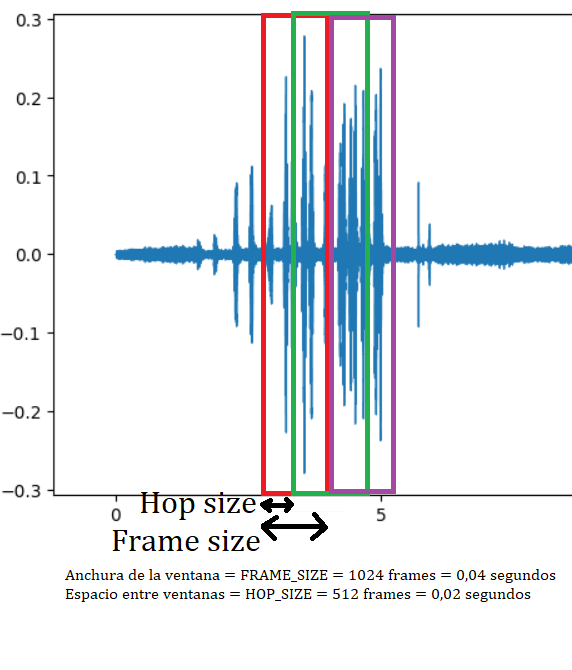

##  Leer los datos de audio, cortarlos y guardarlos

In [ ]:
input_folder = r'/content/drive/MyDrive/BigData/DataMining/Practica1/Audiofiles/'
output_folder = r'/content/drive/MyDrive/BigData/DataMining/Practica1/Audio_Clip'
def trim_and_save_audio(input_folder, output_folder):
    for bird_folder in os.listdir(input_folder):
        bird_folder_path = os.path.join(input_folder, bird_folder)
        print(bird_folder)
        if os.path.isdir(bird_folder_path):
            output_bird_folder_path = os.path.join(output_folder, bird_folder)
            os.makedirs(output_bird_folder_path, exist_ok=True)


            for audio_file in os.listdir(bird_folder_path):
                if audio_file.endswith(".mp3"):
                    audio_path = os.path.join(bird_folder_path, audio_file)
                    text_file_path = os.path.join(bird_folder_path, audio_file.replace(".mp3", ".txt"))


                    if os.path.exists(text_file_path):
                        with open(text_file_path, 'r') as text_file:
                            lines = text_file.readlines()


                            for i, line in enumerate(lines, start=1):
                                start_time, end_time, _ = line.strip().split('\t')
                                start_time, end_time = float(start_time), float(end_time)
                                print(f"Start: {start_time}, end: {end_time}")


                                # Load audio with librosa
                                y, sr = librosa.load(audio_path, sr=None)


                                # Trim audio
                                start_frame = int(start_time * sr)
                                end_frame = int(end_time * sr)
                                trimmed_audio = y[start_frame:end_frame]


                                # Save trimmed audio
                                output_audio_name = f"{os.path.splitext(audio_file)[0]}_{i}.wav"
                                output_audio_path = os.path.join(output_bird_folder_path, output_audio_name)
                                sf.write(output_audio_path, trimmed_audio, sr)


                                print(f"Trimmed audio saved: {output_audio_path}")
trim_and_save_audio(input_folder, output_folder)

Acrocephalus scirpaceus
Start: 0.0, end: 33.208639
Trimmed audio saved: /content/drive/MyDrive/BigData/DataMining/Practica1/Audio_Clip/Acrocephalus scirpaceus/XC519994_1.wav
Start: 37.926034, end: 42.830275
Trimmed audio saved: /content/drive/MyDrive/BigData/DataMining/Practica1/Audio_Clip/Acrocephalus scirpaceus/XC519994_2.wav
Start: 48.294975, end: 65.296313
Trimmed audio saved: /content/drive/MyDrive/BigData/DataMining/Practica1/Audio_Clip/Acrocephalus scirpaceus/XC519994_3.wav
Start: 69.593339, end: 79.168259
Trimmed audio saved: /content/drive/MyDrive/BigData/DataMining/Practica1/Audio_Clip/Acrocephalus scirpaceus/XC519994_4.wav


KeyboardInterrupt: 

## Obtener las características del audio por ventanas

In [ ]:
FRAME_SIZE = 1024 # Muestras que tiene la ventana de audio analizada.
HOP_LENGTH = 512 # Muestras que se santan de ventana en ventana.
N_MFCC = 13 # Número de MFCC

def amplitude_mean_max_values(signal, frame_size, hop_length):
    amplitude_values = []
    # Iteramos sobre la señal de audio. Desde 0 hasta su longitud con el paso definido por hop_length.
    for i in range(0, len(signal), hop_length):
        # De la señal tomamos una ventana de valores.
        # Empezando en el momento de tiempo "i" hasta "i" + la longitud de la ventana (frame_size)
        window = signal[i:i+frame_size]
        # Agregamos el valor máximo de esta ventana a la lista de valores de la amplitud
        amplitude_values.append(max(window))

    # Devolvemos la media de los valores de la envolvente de amplitud como indicativo de intensidad del canto.
    return np.mean(amplitude_values)

def root_mean_squared(signal, frame_size, hop_length):
    rms = []
    # Iteramos sobre la señal de audio. Desde 0 hasta su longitud con el paso definido por hop_length.
    for i in range(0, len(signal), hop_length):
        # Raíz de sumar los valores de la señal en esa ventana al cuadrado y dividirlo por el tamaño de la ventana.
        rms_current_frame = np.sqrt(sum(signal[i:i+frame_size]**2) / frame_size)
        rms.append(rms_current_frame)
    return np.mean(rms)

def calcular_caracteristicas (y,sr,FRAME_SIZE,HOP_LENGTH):
  # Calcular las características del audio
  mfcc = librosa.feature.mfcc(y=y, n_mfcc=13, sr=sr)
  mfcc_scaled = np.mean(mfcc, axis=1)
  delta1_mfcc = librosa.feature.delta(mfcc_scaled, mode='nearest')
  delta2_mfcc = librosa.feature.delta(mfcc_scaled, mode='nearest', order=2)
  zcr = librosa.feature.zero_crossing_rate(y=y)
  rms = root_mean_squared(y, frame_size=FRAME_SIZE, hop_length=HOP_LENGTH)
  amplitude = amplitude_mean_max_values(y, frame_size=FRAME_SIZE, hop_length=HOP_LENGTH)
  for feature in mfcc.T:
    fila = feature.tolist() + [audio_file]
  spectral_centroid = lb.feature.spectral_centroid(y=y, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)
  spectral_flux = lb.onset.onset_strength(S=lb.feature.melspectrogram(y=y, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH))
  spectral_bandwidth = lb.feature.spectral_bandwidth(y=y, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)

  features = np.concatenate(
  (zcr, rms, spectral_centroid, spectral_flux, spectral_bandwidth, mfcc.T, delta1_mfcc,delta2_mfcc), axis=1
    )
  df
  for feature in features:
      row = feature.tolist()
      row.append(bird_name)
      data.append(row)
  return (features)

### 0- Audios de distinta longitud.
Se obtienen las características con el problema de que los audios son de distinta longitud por lo que los datos de mfcc no son de la misma longitud en todos los audios analizados

In [ ]:
audio_folder = "/content/drive/MyDrive/BigData/DataMining/Practica1/Audio_Clip/"
def extract_audio_features(audio_folder):
    audio_features_data = []
    # Iterar sobre las carpetas de las especies
    for species_folder in os.listdir(audio_folder):
        species_folder_path = os.path.join(audio_folder, species_folder)
        if os.path.isdir(species_folder_path):
            # Iterar sobre los archivos de audio dentro de cada carpeta de especies
            for audio_file in os.listdir(species_folder_path):
                audio_path = os.path.join(species_folder_path, audio_file)
                try:
                    y, sr = librosa.load(audio_path)
                except Exception as e:
                    print(f"Error al cargar el archivo {audio_file}: {e}")
                    continue
                if len(y) < FRAME_SIZE*2:
                    print(f"La señal de audio {audio_file} es demasiado corta para calcular características.")
                    continue

                # Calcular las características del audio
                mfcc = librosa.feature.mfcc(y=y, n_mfcc=N_MFCC, sr=sr)
                #Al calcular mfcc utilizando librosa.feature.mfcc, se obteniene una matriz donde
                #cada fila representa un coeficiente MFCC y cada columna representa un segmento de tiempo en el audio.
                #Por lo tanto, cada elemento de mfcc es una lista de valores MFCC para un coeficiente específico.
                mfcc_list = mfcc.tolist()  # Convertir la matriz MFCC a una lista de listas
                mfcc_scaled = np.mean(mfcc, axis=1)
                delta1_mfcc = librosa.feature.delta(mfcc_scaled, mode='nearest')
                delta2_mfcc = librosa.feature.delta(mfcc_scaled, mode='nearest', order=2)
                zcr = librosa.feature.zero_crossing_rate(y=y)
                rms = root_mean_squared(y, frame_size=FRAME_SIZE, hop_length=HOP_LENGTH)
                amplitude = amplitude_mean_max_values(y, frame_size=FRAME_SIZE, hop_length=HOP_LENGTH)

                # Crear un diccionario con las características
                audio_feature_dict = {'Directorio': species_folder,
                    'NombreArchivo': audio_file,
                    'ZCR': np.mean(zcr),
                    'RMS': rms,
                    'Amplitude Mean Max Values': amplitude,
                    'mfcc': mfcc_list,
                    'delta1': delta1_mfcc,
                    'delta2': delta2_mfcc}
                audio_features_data.append(audio_feature_dict)

    # Convertir la lista de diccionarios a DataFrame
    df = pd.DataFrame(audio_features_data)
    return df
df = extract_audio_features(audio_folder)

La señal de audio XC463509_5.wav es demasiado corta para calcular características.
La señal de audio XC526231_4.wav es demasiado corta para calcular características.
La señal de audio XC526231_3.wav es demasiado corta para calcular características.
La señal de audio XC522273_10.wav es demasiado corta para calcular características.
La señal de audio XC376956_7.wav es demasiado corta para calcular características.
La señal de audio XC376956_8.wav es demasiado corta para calcular características.
La señal de audio XC371003_2.wav es demasiado corta para calcular características.
La señal de audio XC371003_3.wav es demasiado corta para calcular características.
La señal de audio XC371003_4.wav es demasiado corta para calcular características.
La señal de audio XC185104_33.wav es demasiado corta para calcular características.
La señal de audio XC185101_3.wav es demasiado corta para calcular características.
La señal de audio XC135658_3.wav es demasiado corta para calcular características.
La

In [ ]:
# Save df1
main_folder = "/content/drive/MyDrive/BigData/DataMining/Practica1/"
df.to_excel(os.path.join(main_folder, "df1.xlsx"), index=False)

0.0- Ya con dataframe guardado.

In [ ]:
# Read df1
main_folder = "/content/drive/MyDrive/BigData/DataMining/Practica1/"
df = pd.read_excel(os.path.join(main_folder, "df1.xlsx"))
df.head()

,Directorio,NombreArchivo,ZCR,RMS,Amplitude Mean Max Values,mfcc,delta1,delta2
0,Acrocephalus scirpaceus,XC519994_1.wav,0.350334,0.053086,0.186741,"[[-678.133056640625, -665.7354125976562, -606....",[44.194862 45.9819 42.068287 34.017334...,[ 7.555218 -2.914259 -13.7925625 -19.52...
1,Acrocephalus scirpaceus,XC519994_3.wav,0.309503,0.024906,0.087854,"[[-462.4371337890625, -428.2746276855469, -427...",[54.179634 54.858383 50.0789 39.975044...,[ 9.1037445 -4.9625015 -17.415651 -23.87...
2,Acrocephalus scirpaceus,XC519994_2.wav,0.281895,0.017204,0.061981,"[[-454.7137756347656, -430.68023681640625, -43...",[59.250458 58.980766 53.242477 42.203358...,[ 9.0494995 -6.940099 -20.17237 -26.12942...
3,Acrocephalus scirpaceus,XC519994_4.wav,0.302783,0.019156,0.071790,"[[-482.96514892578125, -447.0843811035156, -44...",[55.935474 56.66222 51.36031 41.307022...,[ 9.4335985 -5.050322 -18.234808 -24.38181...
4,Acrocephalus scirpaceus,XC511190_1.wav,0.396513,0.022031,0.080857,"[[-429.8829345703125, -385.584228515625, -396....",[60.59404 64.06612 59.44525 48.674057...,[ 11.357642 -2.3964965 -17.509674 -26.36...


In [ ]:
# Leer el primer dato de la columna 'mfcc'
primer_dato_mfcc = df.at[0, 'mfcc']
print("Primer dato de la columna 'mfcc':", primer_dato_mfcc)
print("Longitud", len(primer_dato_mfcc))
print("Tipo", type(primer_dato_mfcc))

Primer dato de la columna 'mfcc': [[-678.133056640625, -665.7354125976562, -606.9320068359375, -559.8303833007812, -518.8900756835938, -488.5306701660156, -469.4980773925781, -452.15087890625, -436.3251953125, -401.5093688964844, -273.9632263183594, -241.01715087890625, -247.7249755859375, -251.89004516601562, -312.2720947265625, -257.304931640625, -202.6630401611328, -237.45535278320312, -256.667724609375, -272.3656921386719, -347.59466552734375, -381.00531005859375, -387.8669738769531, -284.6344909667969, -224.00296020507812, -236.5426025390625, -211.50875854492188, -233.38821411132812, -343.70703125, -399.81134033203125, -401.06756591796875, -313.79718017578125, -224.81777954101562, -219.50148010253906, -229.6775665283203, -245.22337341308594, -323.73309326171875, -382.9150085449219, -389.4579162597656, -397.233642578125, -417.17913818359375, -333.47979736328125, -253.83648681640625, -232.9178009033203, -233.1678924560547, -226.18264770507812, -215.2303009033203, -222.56224060058594

In [ ]:
# Leer el primer dato de la columna 'delta1'
primer_dato_delta1 = df.at[0, 'delta1']
print("Primer dato de la columna 'delta1':", primer_dato_delta1)
print("Longitud", len(primer_dato_delta1))
print("Tipo", type(primer_dato_delta1))

Primer dato de la columna 'delta1': [44.194862   45.9819     42.068287   34.017334   22.393913    5.555806
  4.827499   -0.07486092  4.9199877   2.7107785   2.9517572   1.8243692
  0.74682593]
Longitud 156
Tipo <class 'str'>


0.1- Tratamos con delta

In [ ]:
# Limpiar los datos quitando corchetes y procesando el string separandolo por los espacios
df['delta1_clean'] = df.delta1.str.replace("[", "").str.replace("]", "").str.split()
df['delta2_clean'] = df.delta2.str.replace("[", "").str.replace("]", "").str.split()
# Sanity check para ver que las longitudes son iguales en todos los casos
print(df['delta1_clean'].apply(len).value_counts())
print(df['delta2_clean'].apply(len).value_counts())

delta1_clean
13    5721
Name: count, dtype: int64
delta2_clean
13    5721
Name: count, dtype: int64


In [ ]:
# Obtener nombre de las columnas para hacer split
delta1_col = ['delta1_' + str(x) for x in range(13)]
delta2_col = ['delta2_' + str(x) for x in range(13)]
print(delta1_col,'\n',delta2_col)

['delta1_0', 'delta1_1', 'delta1_2', 'delta1_3', 'delta1_4', 'delta1_5', 'delta1_6', 'delta1_7', 'delta1_8', 'delta1_9', 'delta1_10', 'delta1_11', 'delta1_12'] 
 ['delta2_0', 'delta2_1', 'delta2_2', 'delta2_3', 'delta2_4', 'delta2_5', 'delta2_6', 'delta2_7', 'delta2_8', 'delta2_9', 'delta2_10', 'delta2_11', 'delta2_12']


In [ ]:
# Crear dataframe con las listas expandidas
df_delta_1 = df['delta1_clean'].apply(pd.Series)
df_delta_1.columns = delta1_col
df_delta_2 = df['delta2_clean'].apply(pd.Series)
df_delta_2.columns = delta2_col

In [ ]:
df_delta_1.head()

,delta1_0,delta1_1,delta1_2,delta1_3,delta1_4,delta1_5,delta1_6,delta1_7,delta1_8,delta1_9,delta1_10,delta1_11,delta1_12
0,44.194862,45.9819,42.068287,34.017334,22.393913,5.555806,4.827499,-0.07486092,4.9199877,2.7107785,2.9517572,1.8243692,0.74682593
1,54.179634,54.858383,50.0789,39.975044,25.191702,4.7756543,5.024153,-0.6516018,3.8622694,2.6938114,2.1110976,1.2452022,0.27013025
2,59.250458,58.980766,53.242477,42.203358,25.297573,3.0685425,4.487866,-0.19920504,3.4754057,3.1900463,2.2761807,1.3365599,0.761307
3,55.935474,56.66222,51.36031,41.307022,25.897673,4.747555,5.447417,-0.06533439,3.6230845,2.7323189,2.1332166,0.7959178,0.10777596
4,60.59404,64.06612,59.44525,48.674057,31.553488,8.278241,2.622171,-2.3172703,0.14783321,-2.4213674,-1.3671844,-1.6038277,-1.4855393


0.2- Tratamos con mfcc

In [ ]:
df['mfcc_clean'] = df['mfcc'].str.replace("[", "").str.replace("]", "").str.split(",")
print(df['mfcc_clean'].apply(len).value_counts().sort_index())
max_length_mfcc = df['mfcc_clean'].apply(len).max()
print(max_length_mfcc)
# Vemos que la columna mfcc no tiene la misma longitud en todos sus elementos

mfcc_clean
65      102
78      140
91      211
104     196
117     162
       ... 
1674      4
1675      1
1676      1
1679      1
1682      1
Name: count, Length: 189, dtype: int64
1682


In [ ]:
# Rellenamos con NaN los elementos hasta que todos llegen a tener 1682 elementos
df['mfcc_clean_completed'] = df['mfcc_clean'].apply(lambda senyal: senyal + [np.nan] * (max_length_mfcc - len(senyal)))
df['mfcc_clean_completed']

0       [-678.133056640625,  -665.7354125976562,  -606...
1       [-462.4371337890625,  -428.2746276855469,  -42...
2       [-454.7137756347656,  -430.68023681640625,  -4...
3       [-482.96514892578125,  -447.0843811035156,  -4...
4       [-429.8829345703125,  -385.584228515625,  -396...
                              ...                        
5716    [-446.1303405761719,  -408.3836364746094,  -40...
5717    [-433.3122863769531,  -388.1478271484375,  -38...
5718    [-497.55999755859375,  -456.82257080078125,  -...
5719    [-487.3194274902344,  -452.9825134277344,  -43...
5720    [-541.7599487304688,  -492.85906982421875,  -4...
Name: mfcc_clean_completed, Length: 5721, dtype: object

In [ ]:
df['mfcc_clean_completed'].apply(len).value_counts() # Para ver que todo tiene la misma longitud.

mfcc_clean_completed
1682    5721
Name: count, dtype: int64

In [ ]:
# Obtener nombre de las columnas para hacer split
mfcc_col = ['mfcc_' + str(x) for x in range(max_length_mfcc)]
print(mfcc_col)

['mfcc_0', 'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13', 'mfcc_14', 'mfcc_15', 'mfcc_16', 'mfcc_17', 'mfcc_18', 'mfcc_19', 'mfcc_20', 'mfcc_21', 'mfcc_22', 'mfcc_23', 'mfcc_24', 'mfcc_25', 'mfcc_26', 'mfcc_27', 'mfcc_28', 'mfcc_29', 'mfcc_30', 'mfcc_31', 'mfcc_32', 'mfcc_33', 'mfcc_34', 'mfcc_35', 'mfcc_36', 'mfcc_37', 'mfcc_38', 'mfcc_39', 'mfcc_40', 'mfcc_41', 'mfcc_42', 'mfcc_43', 'mfcc_44', 'mfcc_45', 'mfcc_46', 'mfcc_47', 'mfcc_48', 'mfcc_49', 'mfcc_50', 'mfcc_51', 'mfcc_52', 'mfcc_53', 'mfcc_54', 'mfcc_55', 'mfcc_56', 'mfcc_57', 'mfcc_58', 'mfcc_59', 'mfcc_60', 'mfcc_61', 'mfcc_62', 'mfcc_63', 'mfcc_64', 'mfcc_65', 'mfcc_66', 'mfcc_67', 'mfcc_68', 'mfcc_69', 'mfcc_70', 'mfcc_71', 'mfcc_72', 'mfcc_73', 'mfcc_74', 'mfcc_75', 'mfcc_76', 'mfcc_77', 'mfcc_78', 'mfcc_79', 'mfcc_80', 'mfcc_81', 'mfcc_82', 'mfcc_83', 'mfcc_84', 'mfcc_85', 'mfcc_86', 'mfcc_87', 'mfcc_88', 'mfcc_89', 'mfcc_90', 'mfcc_91

In [ ]:
df_mfcc = df['mfcc_clean_completed'].apply(pd.Series)
df_mfcc.columns = mfcc_col
df_mfcc.head()

,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,...,mfcc_1672,mfcc_1673,mfcc_1674,mfcc_1675,mfcc_1676,mfcc_1677,mfcc_1678,mfcc_1679,mfcc_1680,mfcc_1681
0,-678.133056640625,-665.7354125976562,-606.9320068359375,-559.8303833007812,-518.8900756835938,-488.5306701660156,-469.4980773925781,-452.15087890625,-436.3251953125,-401.5093688964844,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-462.4371337890625,-428.2746276855469,-427.4926452636719,-414.8177185058594,-382.06207275390625,-355.60980224609375,-341.6083068847656,-325.211669921875,-346.9338684082031,-397.5595703125,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-454.7137756347656,-430.68023681640625,-436.2351989746094,-431.6363830566406,-429.8172607421875,-417.93988037109375,-387.6861267089844,-359.60394287109375,-340.6495361328125,-332.76385498046875,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-482.96514892578125,-447.0843811035156,-446.0654296875,-448.3171691894531,-432.27105712890625,-384.96551513671875,-365.5605163574219,-347.0451965332031,-351.78668212890625,-342.1983642578125,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-429.8829345703125,-385.584228515625,-396.56768798828125,-404.4947509765625,-402.93975830078125,-402.531494140625,-406.73553466796875,-400.495361328125,-365.6083679199219,-335.64044189453125,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: >

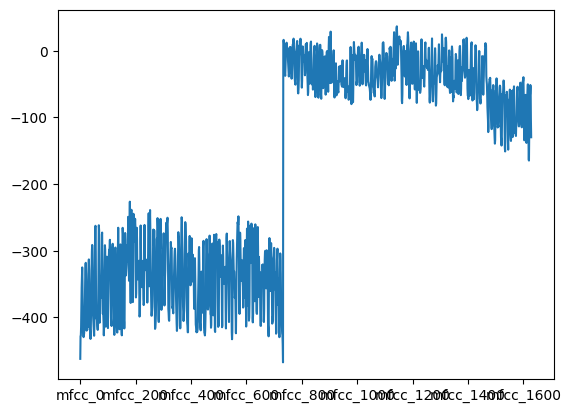

In [ ]:
df_mfcc.iloc[1].astype(float).plot()

<Axes: >

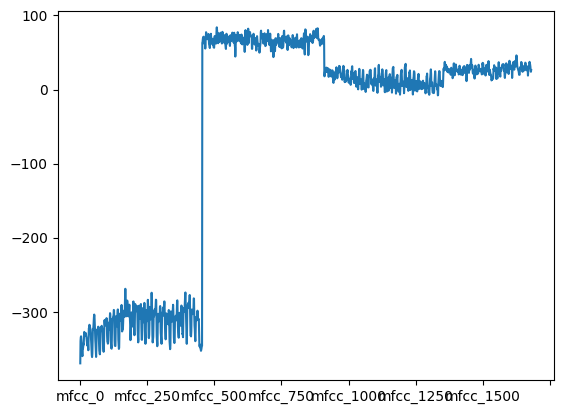

In [ ]:
df_mfcc.iloc[5069].astype(float).plot()

<Axes: >

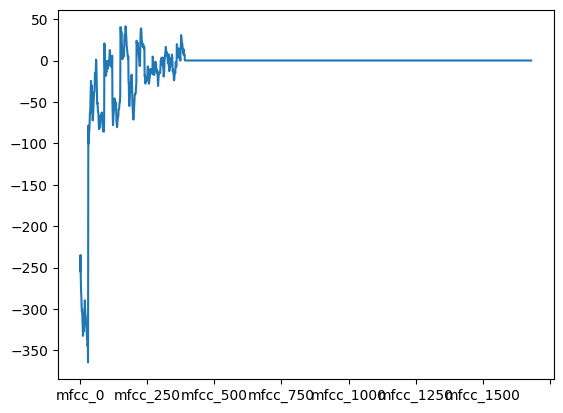

In [ ]:
df_mfcc.iloc[800].fillna(0).astype(float).plot()

En esta última imagen vemos que no es muy buena idea rellenar con valores 0 los valores que faltan de las mfcc.

## 1- Longitud de los audios a max_length

In [ ]:
audio_folder = "/content/drive/MyDrive/BigData/DataMining/Practica1/Audio_Clip"
def extract_audio_features(audio_folder):
    audio_features_data = []
    # Iterar sobre las carpetas de las especies
    for species_folder in os.listdir(audio_folder):
      species_folder_path = os.path.join(audio_folder, species_folder)
      if os.path.isdir(species_folder_path):
          # Iterar sobre los archivos de audio dentro de cada carpeta de especies
          for audio_file in os.listdir(species_folder_path):
              audio_path = os.path.join(species_folder_path, audio_file)
              try:
                  y, sr = librosa.load(audio_path)
              except Exception as e:
                  print(f"Error al cargar el archivo {audio_file}: {e}")
                  continue
              if len(y) < FRAME_SIZE*2:
                    print(f"La señal de audio {audio_file} es demasiado corta para calcular características.")
                    continue
              # Calcular las características del audio
              mfcc = librosa.feature.mfcc(y=y, n_mfcc=N_MFCC, sr=sr)
              mfcc_scaled = np.mean(mfcc, axis=1)
              delta1_mfcc = librosa.feature.delta(mfcc_scaled, mode='nearest')
              delta2_mfcc = librosa.feature.delta(mfcc_scaled, mode='nearest', order=2)
              zcr = librosa.feature.zero_crossing_rate(y=y)
              rms = root_mean_squared(y, frame_size=FRAME_SIZE, hop_length=HOP_LENGTH)
              amplitude = amplitude_mean_max_values(y, frame_size=FRAME_SIZE, hop_length=HOP_LENGTH)

              # Crear un diccionario con las características
              audio_feature_dict = {
                  'Directorio': species_folder,
                  'NombreArchivo': audio_file,
                  'ZCR': np.mean(zcr),
                  'RMS': rms,
                  'Amplitude Mean Max Values': amplitude,
                  'delta1': delta1_mfcc,
                  'delta2': delta2_mfcc
              }
              audio_features_data.append(audio_feature_dict)
     # Convertir la lista de diccionarios a DataFrame
    df = pd.DataFrame(audio_features_data)
    return df
df = extract_audio_features(audio_folder)
df.head()

KeyboardInterrupt: 

In [ ]:
# Save df_Base
main_folder = "/content/drive/MyDrive/BigData/DataMining/Practica1/"
df.to_excel(os.path.join(main_folder, "df_Base.xlsx"), index=False)

1.2 - Limpiar deltas

In [ ]:
# Read df_Base
main_folder = "/content/drive/MyDrive/BigData/DataMining/Practica1/"
df = pd.read_excel(os.path.join(main_folder, "df_Base.xlsx"))
df.head()

In [ ]:
# Limpiar los datos quitando corchetes y procesando el string separandolo por los espacios
df['delta1_clean'] = df.delta1.str.replace("[", "").str.replace("]", "").str.split()
df['delta2_clean'] = df.delta2.str.replace("[", "").str.replace("]", "").str.split()
# Sanity check para ver que las longitudes son iguales en todos los casos
print(df['delta1_clean'].apply(len).value_counts())
print(df['delta2_clean'].apply(len).value_counts())

In [ ]:
# Obtener nombre de las columnas para hacer split
delta1_col = ['delta1_' + str(x) for x in range(13)]
delta2_col = ['delta2_' + str(x) for x in range(13)]
print(delta1_col,'\n',delta2_col)

In [ ]:
# Crear dataframe con las listas expandidas
df_delta_1 = df['delta1_clean'].apply(pd.Series)
df_delta_1.columns = delta1_col
df_delta_2 = df['delta2_clean'].apply(pd.Series)
df_delta_2.columns = delta2_col

In [ ]:
df_delta_1.head()

1.3. Pillar la longitud máxima del audio

In [ ]:
audio_folder = "/content/drive/MyDrive/BigData/DataMining/Practica1/Audio_Clip"
def get_max_len_audio(audio_folder) -> int:
  max_len = 0
  # Iterar sobre las carpetas de las especies
  for species_folder in os.listdir(audio_folder):
    species_folder_path = os.path.join(audio_folder, species_folder)
    if os.path.isdir(species_folder_path):
        # Iterar sobre los archivos de audio dentro de cada carpeta de especies
        for audio_file in os.listdir(species_folder_path):
            audio_path = os.path.join(species_folder_path, audio_file)
            try:
                y, sr = librosa.load(audio_path)
                challenger_len = len(y)
                if challenger_len > max_len:
                  max_len = challenger_len
            except Exception as e:
                print(f"Error al cargar el archivo {audio_file}: {e}")
                continue
  return max_len

max_len = get_max_len_audio(audio_folder)

In [ ]:
print(max_len) #max_len=3096042

1.4. Cargar audios y hacer zero padding para calcular mfcc.

Zero padding = Añadir ceros a los audios hasta que todos tengan la longitud de max_len

In [ ]:
audio_folder = "/content/drive/MyDrive/BigData/DataMining/Practica1/Audio_Clip"
def extract_audio_features(audio_folder):
    audio_features_data = []
    # Iterar sobre las carpetas de las especies
    for species_folder in os.listdir(audio_folder):
      species_folder_path = os.path.join(audio_folder, species_folder)
      if os.path.isdir(species_folder_path):
          # Iterar sobre los archivos de audio dentro de cada carpeta de especies
          for audio_file in os.listdir(species_folder_path):
              audio_path = os.path.join(species_folder_path, audio_file)
              try:
                  y, sr = librosa.load(audio_path)
                  if len(y) < FRAME_SIZE*2:
                    continue
                  expanded_y = np.zeros(max_len, dtype=y.dtype)
                  expanded_y[:len(y)] = y
                  y = expanded_y
              except Exception as e:
                  print(f"Error al cargar el archivo {audio_file}: {e}")
                  continue
              mfcc = librosa.feature.mfcc(y=y, n_mfcc=N_MFCC, sr=sr)
              #Al calcular mfcc utilizando librosa.feature.mfcc, se obteniene una matriz donde
              #cada fila representa un coeficiente MFCC y cada columna representa un segmento de tiempo en el audio.
              #Por lo tanto, cada elemento de mfcc es una lista de valores MFCC para un coeficiente específico.
              mfcc_list = mfcc.tolist()  # Convertir la matriz MFCC a una lista de listas

              # Crear un diccionario
              audio_feature_dict = {
                  'mfcc': mfcc_list
              }
              audio_features_data.append(audio_feature_dict)
     # Convertir la lista de diccionarios a DataFrame
    df = pd.DataFrame(audio_features_data)
    return df
df_mfcc = extract_audio_features(audio_folder)
df_mfcc.head()

**1.5. Procesar mfcc.**

Como se han arreglado las longitudes de las señales, ahora las mfcc tendrían que tener siempre la misma longitud.

In [ ]:
df['mfcc_clean'] = df['mfcc'].str.replace("[", "").str.replace("]", "").str.split(",")
df['flag'] = df['mfcc_clean'].apply(len)
df['flag'].value_counts()
max_length_mfcc = df['flag'].max()

In [ ]:
max_length_mfcc

In [ ]:
df['flag'].value_counts().sort_index()

## 2- Longitud de los audios a 1 segundo

Encontramos la duración de los cantos de los distintos pájaros en el paper **Western Mediterranean wetlands bird species classification: evaluating
small-footprint deep learning approaches on a new annotated dataset** *Juan Gómez-Gómez, Ester Vidaña-Vila, Xavier Sevillano.*

Dados los resultados consideramos tener los audios a 1s ya que la mayoría de los audios están alrededor de ese valor. Los audios que sean mayores a 1s serán cortados en trozos de 1s. Los que sean menores a 1s, se hará zero padding hasta 1s.

1.1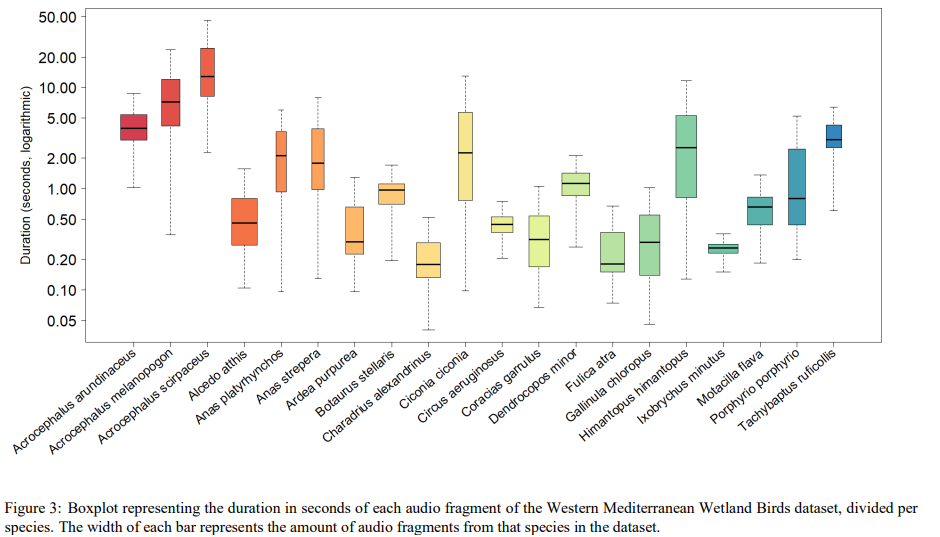

2.1. **MFCC**

In [ ]:
audio_folder = "/content/drive/MyDrive/BigData/DataMining/Practica1/Audio_Clip/"
max_length = 1 # Segundos que van a tener todos los audios
def extract_audio_features(audio_folder):
    audio_features_data = []
    # Iterar sobre las carpetas de las especies
    for species_folder in os.listdir(audio_folder):
        species_folder_path = os.path.join(audio_folder, species_folder)
        if os.path.isdir(species_folder_path):
            # Iterar sobre los archivos de audio dentro de cada carpeta de especies
            for audio_file in os.listdir(species_folder_path):
                audio_path = os.path.join(species_folder_path, audio_file)
                try:
                    y, sr = librosa.load(audio_path)
                    if len(y) < FRAME_SIZE*2: # Si el audio es más pequeño que 2 ventanas de análisis, no se analiza.
                        continue
                    if len(y) < max_length*sr: # Si el audio es más pequeño que 1 segundo, hace zero padding
                        expanded_y = np.zeros(max_length * sr, dtype=y.dtype)
                        expanded_y[:len(y)] = y
                        y = expanded_y
                        # Calcular los MFCC
                        mfcc = librosa.feature.mfcc(y=y, n_mfcc=N_MFCC, sr=sr)
                        for feature in mfcc.T:
                          fila = feature.tolist() + [audio_file]
                          audio_features_data.append(fila)
                    else: # Si el audio es más grande que 1 segundo, corta el audio a pedazos de 1 segundo.
                        num_segments = len(y) // (max_length * sr)  # Número de segmentos que se pueden obtener
                        for i in range(num_segments):
                            segment = y[i * max_length * sr: (i + 1) * max_length * sr] # Corte del segmento
                            # Calcular los MFCC
                            mfcc = librosa.feature.mfcc(y=segment, n_mfcc=N_MFCC, sr=sr)
                            for feature in mfcc.T:
                              fila = feature.tolist() + [audio_file]
                              audio_features_data.append(fila)
                except Exception as e:
                    print(f"Error al cargar el archivo {audio_file}: {e}")

    columns = [f'mfcc_{i + 1}' for i in range(N_MFCC)] + ['label']
    df = pd.DataFrame(audio_features_data,columns=columns)
    return df

df = extract_audio_features(audio_folder)

In [ ]:
###EDWIN
audio_folder = "/content/drive/MyDrive/BigData/DataMining/Practica1/Audio_Clip/"
max_length = 1 # Segundos que van a tener todos los audios
def extract_audio_features(audio_folder):
    audio_features_data = []
    audio_file="XC520116_3.wav"
    audio_path="/content/drive/MyDrive/BigData/DataMining/Practica1/Audio_Clip/Tachybaptus ruficollis/XC520116_3.wav"
    try:
        y, sr = librosa.load(audio_path)
        print (len(y), len(y) // (max_length * sr))
        #if len(y) < FRAME_SIZE*2: # Si el audio es más pequeño que 2 ventanas de análisis, no se analiza.
        if len(y) < max_length*sr: # Si el audio es más pequeño que 1 segundo, hace zero padding
          expanded_y = np.zeros(max_length * sr, dtype=y.dtype)
          expanded_y[:len(y)] = y
          y = expanded_y
          # Calcular los MFCC
          mfcc = librosa.feature.mfcc(y=y, n_mfcc=13, sr=sr)
          for feature in mfcc.T:
            fila = feature.tolist() + [audio_file]
            audio_features_data.append(fila)
        else: # Si el audio es más grande que 1 segundo, corta el audio a pedazos de 1 segundo.
          num_segments = len(y) // (max_length * sr)  # Número de segmentos que se pueden obtener
          for i in range(num_segments):
            segment = y[i * max_length * sr: (i + 1) * max_length * sr] # Corte del segmento
            # Calcular los MFCC
            mfcc = librosa.feature.mfcc(y=segment, n_mfcc=13, sr=sr)
            for feature in mfcc.T:
              fila = feature.tolist() + [audio_file]
              audio_features_data.append(fila)
    except Exception as e:
        print(f"Error al cargar el archivo {audio_file}: {e}")

    columns = [f'mfcc_{i + 1}' for i in range(N_MFCC)] + ['label']
    df = pd.DataFrame(audio_features_data,columns=columns)
    return df

df = extract_audio_features(audio_folder)
df.tail()

93911 4


,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,label
171,-315.301331,-5.848831,-65.416862,8.978065,5.288009,-0.738071,-12.247128,-3.816713,1.297370,8.025129,-4.258082,1.059477,7.288797,XC520116_3.wav
172,-321.562103,-9.175702,-53.801392,17.994705,2.137032,-6.689257,-19.886723,-4.310519,3.876053,8.920053,-4.587726,4.388516,6.050653,XC520116_3.wav
173,-324.013855,-13.279079,-54.440575,13.305264,-3.414073,-6.892371,-20.536247,-3.253117,3.529598,7.855464,-5.043503,4.882249,8.902754,XC520116_3.wav
174,-322.345490,-8.297377,-53.038853,14.398164,-1.625725,-3.546311,-24.083229,-5.297355,-1.018085,4.213499,-3.082471,6.417124,7.181515,XC520116_3.wav
175,-352.319305,0.088003,-48.960106,20.512667,5.359380,-0.084772,-20.556465,-5.062695,0.193050,3.485247,-6.166688,0.738959,3.162125,XC520116_3.wav


In [ ]:
###EDWIN
audio_folder = "/content/drive/MyDrive/BigData/DataMining/Practica1/Audio_Clip/"
max_length = 1 # Segundos que van a tener todos los audios
def extract_audio_features(audio_folder):
    df = pd.DataFrame()
    audio_file="XC520116_3.wav"
    audio_path="/content/drive/MyDrive/BigData/DataMining/Practica1/Audio_Clip/Tachybaptus ruficollis/XC520116_3.wav"
    try:
        y, sr = librosa.load(audio_path)
        print (len(y), len(y) // (max_length * sr))
        #if len(y) < FRAME_SIZE*2: # Si el audio es más pequeño que 2 ventanas de análisis, no se analiza.
        if len(y) < max_length*sr: # Si el audio es más pequeño que 1 segundo, hace zero padding
          # Calcular las caracteristicas
          mfcc = librosa.feature.mfcc(y=y, n_mfcc=13, sr=sr)
          frame_size = len(segment) // 4
          hop_length = frame_size // 4
          #caracteristicas = calcular_caracteristicas (y,sr,frame_size,hop_length)
          for feature in mfcc.T:
            fila = feature.tolist() + [audio_file]
            df = pd.concat([df, pd.DataFrame([fila])], ignore_index=True)
        else: # Si el audio es más grande que 1 segundo, corta el audio a pedazos de 1 segundo.
          num_segments = len(y) // (max_length * sr)  # Número de segmentos que se pueden obtener
          for i in range(num_segments):
            segment = y[i * max_length * sr: (i + 1) * max_length * sr] # Corte del segmento
            # Calcular las caracteristicas
            mfcc = librosa.feature.mfcc(y=segment, n_mfcc=13, sr=sr)
            frame_size = len(segment) // 4
            hop_length = frame_size // 4
            #caracteristicas=calcular_caracteristicas (y,sr,frame_size,hop_length)
            for feature in mfcc.T:
              fila = feature.tolist() + [audio_file]
              df = pd.concat([df, pd.DataFrame([fila])], ignore_index=True)
    except Exception as e:
        print(f"Error al cargar el archivo {audio_file}: {e}")
    df.columns = [f'mfcc_{i + 1}' for i in range(13)] + ['label']
    return df

df = extract_audio_features(audio_folder)
df.tail()

93911 4


,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,label
171,-315.301331,-5.848831,-65.416862,8.978065,5.288009,-0.738071,-12.247128,-3.816713,1.297370,8.025129,-4.258082,1.059477,7.288797,XC520116_3.wav
172,-321.562103,-9.175702,-53.801392,17.994705,2.137032,-6.689257,-19.886723,-4.310519,3.876053,8.920053,-4.587726,4.388516,6.050653,XC520116_3.wav
173,-324.013855,-13.279079,-54.440575,13.305264,-3.414073,-6.892371,-20.536247,-3.253117,3.529598,7.855464,-5.043503,4.882249,8.902754,XC520116_3.wav
174,-322.345490,-8.297377,-53.038853,14.398164,-1.625725,-3.546311,-24.083229,-5.297355,-1.018085,4.213499,-3.082471,6.417124,7.181515,XC520116_3.wav
175,-352.319305,0.088003,-48.960106,20.512667,5.359380,-0.084772,-20.556465,-5.062695,0.193050,3.485247,-6.166688,0.738959,3.162125,XC520116_3.wav


In [ ]:
df.head()

,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,label
0,-429.882935,-90.095657,-40.924725,40.081123,-30.827820,35.484558,-1.357640,-2.950779,13.834057,5.953311,-4.054799,-13.940969,-3.963633,XC511190_1.wav
1,-385.584229,-86.685059,-38.390869,28.573822,-26.966404,28.699261,2.813434,1.215708,11.461064,0.230451,-2.321880,-6.862772,-1.688615,XC511190_1.wav
2,-396.567688,-77.299011,-35.663445,20.057819,-18.475790,17.020832,5.407064,2.905455,8.349464,4.811940,2.317759,-2.120506,-0.380470,XC511190_1.wav
3,-404.494751,-69.688568,-36.113373,20.644066,-11.621761,13.643366,7.648368,3.694915,7.634767,13.915520,0.525363,-6.184756,-5.136070,XC511190_1.wav
4,-402.939758,-60.449081,-45.597721,8.482203,-10.001711,19.382656,12.268195,4.296360,0.819613,14.145687,-2.289358,-6.943088,-3.259063,XC511190_1.wav


In [ ]:
# Save df_mfcc
main_folder = "/content/drive/MyDrive/BigData/DataMining/Practica1/"
df.to_parquet(os.path.join(main_folder, "df_mfcc.parquet"), index=False)

In [ ]:
# Read df_mfcc
main_folder = "/content/drive/MyDrive/BigData/DataMining/Practica1/"
df_mfcc = pd.read_parquet(os.path.join(main_folder, "df_mfcc.parquet"))
df_mfcc.head()

,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,label
0,-429.882935,-90.095657,-40.924725,40.081123,-30.827820,35.484558,-1.357640,-2.950779,13.834057,5.953311,-4.054799,-13.940969,-3.963633,XC511190_1.wav
1,-385.584229,-86.685059,-38.390869,28.573822,-26.966404,28.699261,2.813434,1.215708,11.461064,0.230451,-2.321880,-6.862772,-1.688615,XC511190_1.wav
2,-396.567688,-77.299011,-35.663445,20.057819,-18.475790,17.020832,5.407064,2.905455,8.349464,4.811940,2.317759,-2.120506,-0.380470,XC511190_1.wav
3,-404.494751,-69.688568,-36.113373,20.644066,-11.621761,13.643366,7.648368,3.694915,7.634767,13.915520,0.525363,-6.184756,-5.136070,XC511190_1.wav
4,-402.939758,-60.449081,-45.597721,8.482203,-10.001711,19.382656,12.268195,4.296360,0.819613,14.145687,-2.289358,-6.943088,-3.259063,XC511190_1.wav


2.2. **DELTA** y otras características

In [ ]:
audio_folder = "/content/drive/MyDrive/BigData/DataMining/Practica1/Audio_Clip/"
max_length = 1 # Segundos que van a tener todos los audios
def extract_audio_features(audio_folder):
    audio_features_data = []
    # Iterar sobre las carpetas de las especies
    for species_folder in os.listdir(audio_folder):
        species_folder_path = os.path.join(audio_folder, species_folder)
        if os.path.isdir(species_folder_path):
            # Iterar sobre los archivos de audio dentro de cada carpeta de especies
            for audio_file in os.listdir(species_folder_path):
                audio_path = os.path.join(species_folder_path, audio_file)
                try:
                    y, sr = librosa.load(audio_path)
                    if len(y) < FRAME_SIZE*2: # Si el audio es más pequeño que 2 ventanas de análisis, no se analiza.
                        continue
                    if len(y) < max_length*sr: # Si el audio es más pequeño que 1 segundo, hace zero padding
                        expanded_y = np.zeros(max_length * sr, dtype=y.dtype)
                        expanded_y[:len(y)] = y
                        y = expanded_y
                        # Calcular las características del audio
                        audio_feature_dict=calcular_caracteristicas (y,sr)
                    else: # Si el audio es más grande que 1 segundo, corta el audio a pedazos de 1 segundo.
                        num_segments = len(y) // (max_length * sr)  # Número de segmentos que se pueden obtener
                        for i in range(num_segments):
                            segment = y[i * max_length * sr: (i + 1) * max_length * sr] # Corte del segmento
                        # Calcular las características del audio
                        audio_feature_dict=calcular_caracteristicas (y,sr)
                except Exception as e:
                    print(f"Error al cargar el archivo {audio_file}: {e}")
                audio_features_data.append(audio_feature_dict)
    df = pd.DataFrame(audio_features_data)
    return df

df = extract_audio_features(audio_folder)

Error al cargar el archivo XC511190_1.wav: calcular_caracteristicas() missing 2 required positional arguments: 'FRAME_SIZE' and 'HOP_LENGTH'


UnboundLocalError: local variable 'audio_feature_dict' referenced before assignment

In [ ]:
def extract_audio_features(audio_folder):
    audio_features_data = []
    # Iterar sobre las carpetas de las especies
    for species_folder in os.listdir(audio_folder):
        species_folder_path = os.path.join(audio_folder, species_folder)
        if os.path.isdir(species_folder_path):
            # Iterar sobre los archivos de audio dentro de cada carpeta de especies
            for audio_file in os.listdir(species_folder_path):
                audio_path = os.path.join(species_folder_path, audio_file)
                try:
                    y, sr = librosa.load(audio_path)
                    if len(y) < FRAME_SIZE * 2: # Si el audio es más pequeño que 2 ventanas de análisis, no se analiza.
                        continue
                    if len(y) < max_length * sr: # Si el audio es más pequeño que 1 segundo, hace zero padding
                        expanded_y = np.zeros(max_length * sr, dtype=y.dtype)
                        expanded_y[:len(y)] = y
                        y = expanded_y
                    # Calcular las características del audio
                    audio_feature_dict = calcular_caracteristicas(y, sr, FRAME_SIZE, HOP_LENGTH, audio_file)  # Pasar audio_file como argumento
                except Exception as e:
                    print(f"Error al cargar el archivo {audio_file}: {e}")
                    continue
                audio_features_data.append(audio_feature_dict)
    df = pd.DataFrame(audio_features_data)
    return df

df = extract_audio_features(audio_folder)


Error al cargar el archivo XC511190_1.wav: calcular_caracteristicas() takes 4 positional arguments but 5 were given
Error al cargar el archivo XC511697_1.wav: calcular_caracteristicas() takes 4 positional arguments but 5 were given
Error al cargar el archivo XC511192_1.wav: calcular_caracteristicas() takes 4 positional arguments but 5 were given
Error al cargar el archivo XC511193_1.wav: calcular_caracteristicas() takes 4 positional arguments but 5 were given
Error al cargar el archivo XC511193_3.wav: calcular_caracteristicas() takes 4 positional arguments but 5 were given
Error al cargar el archivo XC511193_4.wav: calcular_caracteristicas() takes 4 positional arguments but 5 were given
Error al cargar el archivo XC511193_2.wav: calcular_caracteristicas() takes 4 positional arguments but 5 were given
Error al cargar el archivo XC511184_1.wav: calcular_caracteristicas() takes 4 positional arguments but 5 were given
Error al cargar el archivo XC485380_1.wav: calcular_caracteristicas() ta

KeyboardInterrupt: 

In [ ]:
df.tail()

,ZCR,RMS,Amplitude Mean Max Values,delta1,delta2
5716,0.290072,0.104015,0.273952,"[76.80648, 80.04622, 71.51122, 56.62569, 33.41...","[10.321835, -6.997395, -26.597351, -35.45777, ..."
5717,0.275280,0.056033,0.145338,"[78.26632, 80.95211, 72.511154, 57.39059, 33.7...","[10.97704, -7.2989645, -26.843737, -35.82199, ..."
5718,0.290771,0.152541,0.351515,"[73.80351, 76.683136, 68.810936, 55.00808, 33....","[10.987972, -6.2221656, -25.095284, -33.772514..."
5719,0.283503,0.132036,0.311256,"[78.958916, 81.94229, 73.41456, 58.729885, 35....","[11.707251, -6.7738976, -26.992493, -36.085808..."
5720,0.503577,0.033902,0.106853,"[75.63171, 79.711075, 70.52001, 57.16884, 33.2...","[11.171335, -5.48377, -26.414614, -34.565323, ..."


In [ ]:
# Sanity check para ver que las longitudes son iguales en todos los casos
df.delta1.apply(len).value_counts()

delta1
13    5721
Name: count, dtype: int64

In [ ]:
# Sanity check para ver que las longitudes son iguales en todos los casos
df.delta2.apply(len).value_counts()

delta2
13    5721
Name: count, dtype: int64

In [ ]:
## Separar las listas delta1 y delta 2.

# Función que convierte cada lista en una Serie de pandas que expande en múltiples columnas
df_delta1_expanded = df['delta1'].apply(pd.Series)
df_delta2_expanded = df['delta2'].apply(pd.Series)

# Nombre de las columnas
df_delta1_expanded.columns = [f'delta1_{i}' for i in range(len(df_delta1_expanded.columns))]
df_delta2_expanded.columns = [f'delta2_{i}' for i in range(len(df_delta2_expanded.columns))]

# Concatenar
df_result = pd.concat([df, df_delta1_expanded], axis=1)
df_result = pd.concat([df_result, df_delta2_expanded], axis=1)
df_delta = df_result

df_delta.tail()

,ZCR,RMS,Amplitude Mean Max Values,delta1,delta2,delta1_0,delta1_1,delta1_2,delta1_3,delta1_4,...,delta2_3,delta2_4,delta2_5,delta2_6,delta2_7,delta2_8,delta2_9,delta2_10,delta2_11,delta2_12
5716,0.290072,0.104015,0.273952,"[76.80648, 80.04622, 71.51122, 56.62569, 33.41...","[10.321835, -6.997395, -26.597351, -35.45777, ...",76.806480,80.046219,71.511223,56.625690,33.414520,...,-35.457771,-30.022078,-3.463501,0.476579,0.892430,-1.347873,2.050524,-0.625478,0.366622,-0.047025
5717,0.275280,0.056033,0.145338,"[78.26632, 80.95211, 72.511154, 57.39059, 33.7...","[10.97704, -7.2989645, -26.843737, -35.82199, ...",78.266319,80.952110,72.511154,57.390591,33.747025,...,-35.821991,-30.357954,-3.287308,-0.545790,1.355381,-0.638428,2.016513,-0.226854,0.409899,-0.234398
5718,0.290771,0.152541,0.351515,"[73.80351, 76.683136, 68.810936, 55.00808, 33....","[10.987972, -6.2221656, -25.095284, -33.772514...",73.803513,76.683136,68.810936,55.008080,33.006374,...,-33.772514,-29.256777,-4.775578,0.361834,1.360882,-1.437320,1.479412,-0.530172,0.608744,0.088433
5719,0.283503,0.132036,0.311256,"[78.958916, 81.94229, 73.41456, 58.729885, 35....","[11.707251, -6.7738976, -26.992493, -36.085808...",78.958916,81.942291,73.414558,58.729885,35.014297,...,-36.085808,-31.348558,-4.598536,0.444717,1.687413,-1.254446,1.830724,-0.448499,0.666516,-0.170976
5720,0.503577,0.033902,0.106853,"[75.63171, 79.711075, 70.52001, 57.16884, 33.2...","[11.171335, -5.48377, -26.414614, -34.565323, ...",75.631706,79.711075,70.520012,57.168839,33.246124,...,-34.565323,-31.523464,-5.262595,0.201522,2.149303,-1.046821,3.360002,-0.238353,1.540765,-0.758474


In [ ]:
# Eliminar las columnas originales
df_delta = df_delta.drop(columns=['delta1', 'delta2'])

df_delta.tail()

,ZCR,RMS,Amplitude Mean Max Values,delta1_0,delta1_1,delta1_2,delta1_3,delta1_4,delta1_5,delta1_6,...,delta2_3,delta2_4,delta2_5,delta2_6,delta2_7,delta2_8,delta2_9,delta2_10,delta2_11,delta2_12
5716,0.290072,0.104015,0.273952,76.806480,80.046219,71.511223,56.625690,33.414520,2.401255,-1.135607,...,-35.457771,-30.022078,-3.463501,0.476579,0.892430,-1.347873,2.050524,-0.625478,0.366622,-0.047025
5717,0.275280,0.056033,0.145338,78.266319,80.952110,72.511154,57.390591,33.747025,2.337464,-0.498869,...,-35.821991,-30.357954,-3.287308,-0.545790,1.355381,-0.638428,2.016513,-0.226854,0.409899,-0.234398
5718,0.290771,0.152541,0.351515,73.803513,76.683136,68.810936,55.008080,33.006374,3.436131,-1.773331,...,-33.772514,-29.256777,-4.775578,0.361834,1.360882,-1.437320,1.479412,-0.530172,0.608744,0.088433
5719,0.283503,0.132036,0.311256,78.958916,81.942291,73.414558,58.729885,35.014297,3.838352,-1.553956,...,-36.085808,-31.348558,-4.598536,0.444717,1.687413,-1.254446,1.830724,-0.448499,0.666516,-0.170976
5720,0.503577,0.033902,0.106853,75.631706,79.711075,70.520012,57.168839,33.246124,3.835309,-3.111880,...,-34.565323,-31.523464,-5.262595,0.201522,2.149303,-1.046821,3.360002,-0.238353,1.540765,-0.758474


In [ ]:
# Save df_delta
main_folder = "/content/drive/MyDrive/BigData/DataMining/Practica1/"
df_delta.to_parquet(os.path.join(main_folder, "df_delta.parquet"), index=False)

In [ ]:
# Read df_delta
main_folder = "/content/drive/MyDrive/BigData/DataMining/Practica1/"
df_delta = pd.read_parquet(os.path.join(main_folder, "df_delta.parquet"))
df_delta.head()

,ZCR,RMS,Amplitude Mean Max Values,delta1_0,delta1_1,delta1_2,delta1_3,delta1_4,delta1_5,delta1_6,...,delta2_3,delta2_4,delta2_5,delta2_6,delta2_7,delta2_8,delta2_9,delta2_10,delta2_11,delta2_12
0,0.396513,0.022031,0.080857,60.594040,64.066116,59.445251,48.674057,31.553488,8.278241,2.622171,...,-26.361362,-24.273886,-6.104630,-3.481495,1.221565,-2.225860,0.456250,-0.395192,0.241463,0.659647
1,0.304556,0.019384,0.074645,71.672691,74.796013,68.765846,54.716415,34.652203,7.176148,4.543885,...,-32.044273,-28.575630,-6.638680,-7.106353,4.932309,0.717915,1.898004,0.148633,-0.448909,0.186453
2,0.319570,0.017728,0.062136,62.396103,64.906944,61.280506,49.523262,30.782555,6.399731,3.040100,...,-26.768091,-25.280313,-6.124643,-6.550598,1.926547,-0.802943,1.296881,1.570525,0.294581,0.011025
3,0.299997,0.045839,0.160839,58.243439,59.693840,56.101093,45.820705,29.322317,7.647822,5.104581,...,-24.572485,-22.681564,-4.848454,-5.335557,3.307777,-1.082155,-0.643225,0.024287,-0.343521,-0.108712
4,0.307196,0.037061,0.130840,57.129494,58.806881,55.378597,45.392479,28.875517,7.335598,5.152662,...,-23.837723,-22.083826,-4.353525,-5.528723,2.100196,-1.580157,-0.555191,0.260245,0.032786,0.082135


2.3 Concatenar df_mfcc y df_delta

In [ ]:
main_folder = "/content/drive/MyDrive/BigData/DataMining/Practica1/"
df_mfcc = pd.read_parquet(os.path.join(main_folder, "df_mfcc.parquet"))
df_mfcc.tail(2)

,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,label
6815039,-484.403137,-37.266403,-17.899147,73.862465,-31.325884,26.260965,29.238869,-7.865005,-0.914665,23.617687,-0.866778,-2.394413,21.547430,XC102794_3.wav
6815040,-523.562195,-18.990318,-13.353973,48.478836,-14.296181,28.978748,20.628059,4.955578,1.955540,13.920181,5.894550,-4.464888,14.035677,XC102794_3.wav


In [ ]:
main_folder = "/content/drive/MyDrive/BigData/DataMining/Practica1/"
df_delta = pd.read_parquet(os.path.join(main_folder, "df_delta.parquet"))
df_delta.tail(2)

,ZCR,RMS,Amplitude Mean Max Values,delta1_0,delta1_1,delta1_2,delta1_3,delta1_4,delta1_5,delta1_6,...,delta2_3,delta2_4,delta2_5,delta2_6,delta2_7,delta2_8,delta2_9,delta2_10,delta2_11,delta2_12
5719,0.283503,0.132036,0.311256,78.958916,81.942291,73.414558,58.729885,35.014297,3.838352,-1.553956,...,-36.085808,-31.348558,-4.598536,0.444717,1.687413,-1.254446,1.830724,-0.448499,0.666516,-0.170976
5720,0.503577,0.033902,0.106853,75.631706,79.711075,70.520012,57.168839,33.246124,3.835309,-3.111880,...,-34.565323,-31.523464,-5.262595,0.201522,2.149303,-1.046821,3.360002,-0.238353,1.540765,-0.758474


In [ ]:
df = pd.concat([df_delta, df_mfcc], axis=1)
df.tail(2)

,ZCR,RMS,Amplitude Mean Max Values,delta1_0,delta1_1,delta1_2,delta1_3,delta1_4,delta1_5,delta1_6,...,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,label
6815039,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-31.325884,26.260965,29.238869,-7.865005,-0.914665,23.617687,-0.866778,-2.394413,21.547430,XC102794_3.wav
6815040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-14.296181,28.978748,20.628059,4.955578,1.955540,13.920181,5.894550,-4.464888,14.035677,XC102794_3.wav


# 2.4. Obtener el mismo número de datos.

Y conservar el nombre de la especie.

In [ ]:
# mfcc code

audio_folder = "/content/drive/MyDrive/BigData/DataMining/Practica1/Audio_Clip/"
max_length = 1 # Segundos que van a tener todos los audios
def extract_audio_features(audio_folder):
    audio_features_data = []
    # Iterar sobre las carpetas de las especies
    for species_folder in os.listdir(audio_folder):
        species_folder_path = os.path.join(audio_folder, species_folder)
        if os.path.isdir(species_folder_path):
            # Iterar sobre los archivos de audio dentro de cada carpeta de especies
            for audio_file in os.listdir(species_folder_path):
                audio_path = os.path.join(species_folder_path, audio_file)
                try:
                    y, sr = librosa.load(audio_path)
                    if len(y) < FRAME_SIZE*2: # Si el audio es más pequeño que 2 ventanas de análisis, no se analiza.
                        continue
                    if len(y) < max_length*sr: # Si el audio es más pequeño que 1 segundo, hace zero padding
                        expanded_y = np.zeros(max_length * sr, dtype=y.dtype)
                        expanded_y[:len(y)] = y
                        y = expanded_y
                        # Calcular los MFCC
                        mfcc = librosa.feature.mfcc(y=y, n_mfcc=N_MFCC, sr=sr)
                        for feature in mfcc.T:
                          fila = feature.tolist() + [audio_file]
                          audio_features_data.append(fila)
                    else: # Si el audio es más grande que 1 segundo, corta el audio a pedazos de 1 segundo.
                        num_segments = len(y) // (max_length * sr)  # Número de segmentos que se pueden obtener
                        for i in range(num_segments):
                            segment = y[i * max_length * sr: (i + 1) * max_length * sr] # Corte del segmento
                            # Calcular los MFCC
                            mfcc = librosa.feature.mfcc(y=y, n_mfcc=N_MFCC, sr=sr)
                            for feature in mfcc.T:
                              fila = feature.tolist() + [audio_file]
                              audio_features_data.append(fila)
                except Exception as e:
                    print(f"Error al cargar el archivo {audio_file}: {e}")

    columns = [f'mfcc_{i + 1}' for i in range(N_MFCC)] + ['label']
    df = pd.DataFrame(audio_features_data,columns=columns)
    return df

df = extract_audio_features(audio_folder)

Error al cargar el archivo XC511190_1.wav: name 'FRAME_SIZE' is not defined
Error al cargar el archivo XC511697_1.wav: name 'FRAME_SIZE' is not defined
Error al cargar el archivo XC511192_1.wav: name 'FRAME_SIZE' is not defined
Error al cargar el archivo XC511193_1.wav: name 'FRAME_SIZE' is not defined
Error al cargar el archivo XC511193_3.wav: name 'FRAME_SIZE' is not defined
Error al cargar el archivo XC511193_4.wav: name 'FRAME_SIZE' is not defined
Error al cargar el archivo XC511193_2.wav: name 'FRAME_SIZE' is not defined
Error al cargar el archivo XC511184_1.wav: name 'FRAME_SIZE' is not defined
Error al cargar el archivo XC485380_1.wav: name 'FRAME_SIZE' is not defined
Error al cargar el archivo XC485380_2.wav: name 'FRAME_SIZE' is not defined
Error al cargar el archivo XC481567_1.wav: name 'FRAME_SIZE' is not defined
Error al cargar el archivo XC476409_2.wav: name 'FRAME_SIZE' is not defined
Error al cargar el archivo XC476409_1.wav: name 'FRAME_SIZE' is not defined
Error al car

KeyboardInterrupt: 

In [ ]:
# delta code

audio_folder = "/content/drive/MyDrive/BigData/DataMining/Practica1/Audio_Clip/"
max_length = 1 # Segundos que van a tener todos los audios
def extract_audio_features(audio_folder):
    audio_features_data = []
    # Iterar sobre las carpetas de las especies
    for species_folder in os.listdir(audio_folder):
        species_folder_path = os.path.join(audio_folder, species_folder)
        if os.path.isdir(species_folder_path):
            # Iterar sobre los archivos de audio dentro de cada carpeta de especies
            for audio_file in os.listdir(species_folder_path):
                audio_path = os.path.join(species_folder_path, audio_file)
                try:
                    y, sr = librosa.load(audio_path)
                    if len(y) < FRAME_SIZE*2: # Si el audio es más pequeño que 2 ventanas de análisis, no se analiza.
                        continue
                    if len(y) < max_length*sr: # Si el audio es más pequeño que 1 segundo, hace zero padding
                        expanded_y = np.zeros(max_length * sr, dtype=y.dtype)
                        expanded_y[:len(y)] = y
                        y = expanded_y
                        # Calcular las características del audio
                        audio_feature_dict=calcular_caracteristicas (y,sr)
                    else: # Si el audio es más grande que 1 segundo, corta el audio a pedazos de 1 segundo.
                        num_segments = len(y) // (max_length * sr)  # Número de segmentos que se pueden obtener
                        for i in range(num_segments):
                            segment = y[i * max_length * sr: (i + 1) * max_length * sr] # Corte del segmento
                        # Calcular las características del audio
                        audio_feature_dict=calcular_caracteristicas (y,sr)
                except Exception as e:
                    print(f"Error al cargar el archivo {audio_file}: {e}")
                audio_features_data.append(audio_feature_dict)
    df = pd.DataFrame(audio_features_data)
    return df

df = extract_audio_features(audio_folder)

Error al cargar el archivo XC511190_1.wav: calcular_caracteristicas() missing 2 required positional arguments: 'FRAME_SIZE' and 'HOP_LENGTH'


UnboundLocalError: local variable 'audio_feature_dict' referenced before assignment

# Modelado de machine learning

## Imports y leer datos

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings(action="default")

In [ ]:
# Leer delta, sin mfcc
main_folder = "/content/drive/MyDrive/BigData/DataMining/Practica1/"
df = pd.read_parquet(os.path.join(main_folder, "df_delta.parquet"))
df.tail(2)

,ZCR,RMS,Amplitude Mean Max Values,delta1_0,delta1_1,delta1_2,delta1_3,delta1_4,delta1_5,delta1_6,...,delta2_3,delta2_4,delta2_5,delta2_6,delta2_7,delta2_8,delta2_9,delta2_10,delta2_11,delta2_12
5719,0.283503,0.132036,0.311256,78.958916,81.942291,73.414558,58.729885,35.014297,3.838352,-1.553956,...,-36.085808,-31.348558,-4.598536,0.444717,1.687413,-1.254446,1.830724,-0.448499,0.666516,-0.170976
5720,0.503577,0.033902,0.106853,75.631706,79.711075,70.520012,57.168839,33.246124,3.835309,-3.111880,...,-34.565323,-31.523464,-5.262595,0.201522,2.149303,-1.046821,3.360002,-0.238353,1.540765,-0.758474


## Separación de los datos

In [ ]:
## Separamos el dataframe según los datos X e y.
X = df.drop(columns=["Directorio"])
X = X.drop(columns=["NombreArchivo"]) # no es una característica a analizar

# Creamos nueva columna "MFCC_mean" con la media de los valores de la "MFCCs"
df['MFCC_mean'] = df['MFCCs'].apply(lambda x: sum(x) / len(x))
X = X.drop(columns=["MFCCs"]) # Quitamos la lista de MFCCs y nos quedamos solo con la media

# El target es adivinar el nombre de la especie, o sea el directorio.
y = df["Directorio"]

# Separamos los datos en un 70% para entrenar el modelo y en un 30% para su testeo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=23)

KeyError: "['Directorio'] not found in axis"

## Entrenamiento

In [ ]:
X_train = X_train.values
y_train = y_train.values

/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


In [ ]:
RF = RandomForestClassifier(max_depth=20, n_estimators = 200, random_state=0)
RF.fit(X_train, y_train)
y_train_pred = RF.predict(X_train)
y_test_pred = RF.predict(X_test)

ValueError: setting an array element with a sequence.

In [ ]:
print(X_train.dtype)
print(y_train.dtype)

object
object


## Resultados

In [ ]:
# Accuracy
print("Accuracy - Datos de train: {} " .format(accuracy_score(y_train, y_train_pred)))
print("Accuracy - Datos de test: {} ". format(accuracy_score(y_test, y_test_pred)))


# Matriz de confusión
confusion_matrix(y_test, y_test_pred)


# Gráfica de las features
number_of_features = list(range(X_train.shape[1]))
print("Feature importances Random forest:", RF.feature_importances_)
plt.barh(number_of_features, RF.feature_importances_)
plt.yticks(number_of_features, X.columns)
plt.xlabel("Feature Importances")
plt.ylabel("Features")
plt.show()


# Gráfica de los árboles
from sklearn import tree
fig, axes = plt.subplots(nrows = 1,ncols = 5,figsize = (20,4))
for index in range(0, 5):
    tree.plot_tree(RF.estimators_[index],
                   feature_names = X.columns,
                   filled = True,
                   impurity=False,
                   ax = axes[index]);


    axes[index].set_title('Estimator: ' + str(index), fontsize = 11)

NameError: name 'y_train_pred' is not defined

# KNN (k-Nearest Neighbors)

## Imports

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

## Separación de los datos

In [ ]:
# Separamos el dataframe según los datos X e y. El target es adivinar el nombre de la especie, o sea el directorio.
X = df.drop(columns=["Directorio"])
X = X.drop(columns=["NombreArchivo"])
y = df["Directorio"]

# Separamos los datos en un 65% para entrenar el modelo y en un 35% para su testeo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=10)

## Entrenamiento

In [ ]:
KNN = KNeighborsClassifier(n_neighbors=7)
KNN.fit(X_train, y_train)
y_train_pred = KNN.predict(X_train)
y_test_pred = KNN.predict(X_test)

/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


ValueError: setting an array element with a sequence.

## Resultados

In [ ]:
# Accuracy de los datos tanto del train como del test.
print("Accuracy - Datos de train: {} " .format(accuracy_score(y_train, y_train_pred)))
print("Accuracy - Datos de test: {} ". format(accuracy_score(y_test, y_test_pred)))

# Barrido con distintos parámetros.
train_score = []
test_score = []
k_value = list(range(10, 30))
for i in k_value:
    KNN = KNeighborsClassifier(n_neighbors=i)
    KNN.fit(X_train,y_train)
    y_train_pred = KNN.predict(X_train)
    train_score.append(accuracy_score(y_train, y_train_pred))
    y_test_pred = KNN.predict(X_test)
    test_score.append(accuracy_score(y_test, y_test_pred))

plt.figure(figsize=(10,6))
plt.plot(k_value, train_score, color="blue", label = "accuracy train")
plt.plot(k_value, test_score, color="red", label = "accuracy test")
plt.legend()

NameError: name 'y_train_pred' is not defined

# CNN (Convolutional Neural Networks)

## Imports

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

## Carga de los espectrogramas

In [ ]:
directorio_principal = r'/content/drive/MyDrive/BigData/DataMining/Practica1/Espectrograms'

espectrogramas = []
for carpeta in os.listdir(directorio_principal):
    carpeta_path = os.path.join(directorio_principal, carpeta)

    # si la ruta es un directorio
    if os.path.isdir(carpeta_path):
        # Iterar sobre los archivos en la carpeta actual
        for archivo in os.listdir(carpeta_path):
            archivo_path = os.path.join(carpeta_path, archivo)
            # Cargar el espectrograma desde el archivo .npy
            espectrograma = np.load(archivo_path)
                # Agregar el espectrograma a la lista
            espectrogramas.append(espectrograma)
df_espectrogramas = pd.DataFrame(np.array(espectrogramas))


## Separación de los datos

In [ ]:
# Separamos los datos de los espectogramas según los datos X e y. El target es adivinar el nombre de la especie, o sea el directorio.
X = df_espectrogramas.drop(columns=["Directorio"])
X = X.drop(columns=["NombreArchivo"])
y = df_espectrogramas["Directorio"]

train_images, test_images, train_labels, test_labels = train_test_split(X, y, random_state=1)

## Entrenamiento

In [ ]:
# Escalamos las imágenes entre 0 y 1
train_images = train_images / 255
test_images = test_images / 255

# Entrenamos el modelo con esas imágenes.
model = tf.keras.Sequential()
history = model.fit(train_images, train_labels, validation_split = 0.1, batch_size = 256, epochs=10)
# Batch_size son cuantas imágenes pasan en grupo por la red de neuronas + backtrain hasta pasar todas las imágenes que se tienen
# El resultado de dividir Nºtotal imagen/batch_size son cuantas han pasadas ha tenido que hacer y es lo que nos  indica en la salida abajo de Epoch que pone NUM/NUM

NameError: name 'train_images' is not defined

## Resultados

In [ ]:
# Accuracy
accuracy = model.evaluate(train_images, train_labels)
print(accuracy[1], "Accuracy en Train",)
accuracy = model.evaluate(test_images, test_labels)
print(accuracy[1], "Accuracy en Test",)

# Matriz de confusión
label_predictions = np.argmax(predictions,axis = 1)
confusion_matrix(test_labels, label_predictions)

# Evolución de la accuracy para cada época
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Evolución de la loss para cada época
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Opciones anteriores de "Lectura y análisis de los datos"

## Opción 0) Lectura de los datos de audio y corte de los tiempos en array


In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np

### Leer los datos

#### 1 archivo

In [ ]:
# Cargar el archivo de audio MP3
mp3_path = '/content/drive/MyDrive/BigData/DataMining/Practica1/Audiofiles/Acrocephalus arundinaceus/XC417157.mp3'
y, sr = librosa.load(mp3_path)

# Mostrar la forma de onda del audio
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr)
plt.title('Forma de Onda del Audio')
plt.show()

In [ ]:
import os
archivo_txt = '/content/drive/MyDrive/BigData/DataMining/Practica1/Audiofiles/Acrocephalus arundinaceus/XC417157.txt'
nombre_base_txt = os.path.splitext(archivo_txt)[0]
print(nombre_base_txt)

#### 1 Directorio

In [ ]:
directorio = '/content/drive/MyDrive/BigData/DataMining/Practica1/Audiofiles/Tachybaptus ruficollis'
contenido_directorio = os.listdir(directorio)

# Filtrar los archivos .txt
archivos_txt = [archivo for archivo in contenido_directorio if archivo.endswith('.txt')]

datos = []
for archivo_txt in archivos_txt:
    # Construir la ruta completa del archivo .txt
    ruta_txt = os.path.join(directorio, archivo_txt)

    # Leer los cortes de tiempo desde el archivo .txt
    with open(ruta_txt, 'r') as file:
        cortes_tiempo = [linea.strip().split('\t') for linea in file]

    # Obtener el nombre base del archivo .txt (sin extensión)
    nombre_base_txt = os.path.splitext(archivo_txt)[0]

    # Iterar sobre los cortes de tiempo
    for corte_tiempo in cortes_tiempo:
        inicio_tiempo = float(corte_tiempo[0])
        fin_tiempo = float(corte_tiempo[1])

        # Construir el nombre del archivo .mp3 correspondiente al .txt actual
        archivo_mp3 = os.path.join(directorio, f"{nombre_base_txt}.mp3")

        # Comprobar si el archivo .mp3 existe
        if os.path.isfile(archivo_mp3):
            # Cargar el archivo .mp3 con librosa
            y, sr = librosa.load(archivo_mp3, sr=None)

            # Convertir los tiempos a índices de muestras. sr=sampling rate
            inicio_muestra = int(inicio_tiempo * sr)
            fin_muestra = int(fin_tiempo * sr)

            # Extraer la porción del audio según los cortes de tiempo
            porcion_audio = y[inicio_muestra:fin_muestra]
            # Agregar la información a la lista de datos
            datos.append({'Directorio': os.path.basename(directorio), 'NombreArchivo': nombre_base_txt, 'Duracion': len(porcion_audio)/sr, 'PorcionAudio': porcion_audio})
        else:
            print(f"No se encontró el archivo MP3 correspondiente a {archivo_txt}")

# Crear un DataFrame con los datos
df = pd.DataFrame(datos)
df.head()

In [ ]:
directorio = '/content/drive/MyDrive/BigData/DataMining/Practica1/Audiofiles/Tachybaptus ruficollis'
contenido_directorio = os.listdir(directorio)

# Filtrar los archivos .txt
archivos_txt = [archivo for archivo in contenido_directorio if archivo.endswith('.txt')]

datos = []
for archivo_txt in archivos_txt:
    # Construir la ruta completa del archivo .txt
    ruta_txt = os.path.join(directorio, archivo_txt)

    # Leer los cortes de tiempo desde el archivo .txt
    with open(ruta_txt, 'r') as file:
        cortes_tiempo = [linea.strip().split('\t') for linea in file]

    # Obtener el nombre base del archivo .txt (sin extensión)
    nombre_base_txt = os.path.splitext(archivo_txt)[0]

    # Iterar sobre los cortes de tiempo
    for corte_tiempo in cortes_tiempo:
        inicio_tiempo = float(corte_tiempo[0])
        fin_tiempo = float(corte_tiempo[1])

        # Construir el nombre del archivo .mp3 correspondiente al .txt actual
        archivo_mp3 = os.path.join(directorio, f"{nombre_base_txt}.mp3")

        # Comprobar si el archivo .mp3 existe
        if os.path.isfile(archivo_mp3):
            # Cargar el archivo .mp3 con librosa
            y, sr = librosa.load(archivo_mp3, sr=None)

            # Convertir los tiempos a índices de muestras. sr=sampling rate
            inicio_muestra = int(inicio_tiempo * sr)
            fin_muestra = int(fin_tiempo * sr)

            # Extraer la porción del audio según los cortes de tiempo
            porcion_audio = y[inicio_muestra:fin_muestra]

            # Extraer las características MFCC
            mfcc = librosa.feature.mfcc(y=porcion_audio, sr=sr)

            # Hacer una lista con las medias de MFCC de cada audio
            datos.append({'Directorio': os.path.basename(directorio), 'NombreArchivo': nombre_base_txt, 'Duracion': len(porcion_audio)/sr, 'MFCC': np.mean(mfcc)})
        else:
            print(f"No se encontró el archivo MP3 correspondiente a {archivo_txt}")

#### Intentando con todos los directorios

Creamos la variable *directorios* que es una lista con los paths de las carpetas de los *Audio files*

In [ ]:
# Ruta de la carpeta principal
carpeta_principal = '/content/drive/MyDrive/BigData/DataMining/Practica1/Audiofiles/'

# Obtener la lista de nombres de directorios en la carpeta principal
nombres_directorios = [nombre for nombre in os.listdir(carpeta_principal) if os.path.isdir(os.path.join(carpeta_principal, nombre))]

# Construir los paths completos de los directorios
directorios = [os.path.join(carpeta_principal, nombre) for nombre in nombres_directorios]

# Ahora, paths_directorios contiene los paths completos de todas las carpetas dentro de la carpeta principal
print(directorios)

In [ ]:
datos = []
# Iterar sobre los directorios
for directorio in directorios:
    # Obtener el contenido del directorio
    contenido_directorio = os.listdir(directorio)

    # Filtrar los archivos .txt
    archivos_txt = [archivo for archivo in contenido_directorio if archivo.endswith('.txt')]

    for archivo_txt in archivos_txt:
        # Construir la ruta completa del archivo .txt
        ruta_txt = os.path.join(directorio, archivo_txt)

        # Leer los cortes de tiempo desde el archivo .txt
        with open(ruta_txt, 'r') as file:
            cortes_tiempo = [linea.strip().split('\t') for linea in file]

        # Obtener el nombre base del archivo .txt (sin extensión)
        nombre_base_txt = os.path.splitext(archivo_txt)[0]

        # Iterar sobre los cortes de tiempo
        for corte_tiempo in cortes_tiempo:
            inicio_tiempo = float(corte_tiempo[0])
            fin_tiempo = float(corte_tiempo[1])

            # Construir el nombre del archivo .mp3 correspondiente al .txt actual
            archivo_mp3 = os.path.join(directorio, f"{nombre_base_txt}.mp3")

            # Comprobar si el archivo .mp3 existe
            if os.path.isfile(archivo_mp3):
                # Cargar el archivo .mp3 con librosa
                y, sr = librosa.load(archivo_mp3, sr=None)

                # Convertir los tiempos a índices de muestras. sr=sampling rate
                inicio_muestra = int(inicio_tiempo * sr)
                fin_muestra = int(fin_tiempo * sr)

                # Extraer la porción del audio según los cortes de tiempo
                porcion_audio = y[inicio_muestra:fin_muestra]

                # Extraer las características MFCC
                mfcc = librosa.feature.mfcc(y=porcion_audio, sr=sr)

                # Hacer una lista con las medias de MFCC de cada audio
                datos.append({'Directorio': os.path.basename(directorio), 'NombreArchivo': nombre_base_txt, 'Duracion': len(porcion_audio)/sr, 'MFCC': np.mean(mfcc)})
            else:
                print(f"No se encontró el archivo MP3 correspondiente a {archivo_txt}")

In [ ]:
# Crear un DataFrame con los datos
df = pd.DataFrame(datos)
df.head()

In [ ]:
import os
import librosa
import pandas as pd

# Lista para almacenar los datos de todos los directorios
datos_totales = []

# Iterar sobre los directorios
for directorio in directorios:
    # Obtener el contenido del directorio
    contenido_directorio = os.listdir(directorio)

    # Filtrar los archivos .txt
    archivos_txt = [archivo for archivo in contenido_directorio if archivo.endswith('.txt')]

    # Lista para almacenar los datos de un directorio específico
    datos = []

    # Iterar sobre los archivos .txt
    for archivo_txt in archivos_txt:
        # Construir la ruta completa del archivo .txt
        ruta_txt = os.path.join(directorio, archivo_txt)

        # Leer los cortes de tiempo desde el archivo .txt
        with open(ruta_txt, 'r') as file:
            cortes_tiempo = [linea.strip().split('\t') for linea in file]

        # Obtener el nombre base del archivo .txt (sin extensión)
        nombre_base_txt = os.path.splitext(archivo_txt)[0]

        # Iterar sobre los cortes de tiempo
        for corte_tiempo in cortes_tiempo:
            inicio_tiempo = float(corte_tiempo[0])
            fin_tiempo = float(corte_tiempo[1])

            # Construir el nombre del archivo .mp3 correspondiente al .txt actual
            archivo_mp3 = os.path.join(directorio, f"{nombre_base_txt}.mp3")

            # Comprobar si el archivo .mp3 existe
            if os.path.isfile(archivo_mp3):
                # Cargar el archivo .mp3 con librosa
                y, sr = librosa.load(archivo_mp3, sr=None)

                # Convertir los tiempos a índices de muestras. sr=sampling rate
                inicio_muestra = int(inicio_tiempo * sr)
                fin_muestra = int(fin_tiempo * sr)

                # Extraer la porción del audio según los cortes de tiempo
                porcion_audio = y[inicio_muestra:fin_muestra]

                # Agregar la información a la lista de datos
                datos.append({'Directorio': os.path.basename(directorio), 'NombreArchivo': nombre_base_txt, 'Duracion': len(porcion_audio)/sr, 'PorcionAudio': porcion_audio})
            else:
                print(f"No se encontró el archivo MP3 correspondiente a {archivo_txt}")

    # Extender la lista de datos totales con los datos del directorio actual
    datos_totales.extend(datos)

# Crear un DataFrame con todos los datos
df = pd.DataFrame(datos_totales)
df.head()

#### Intentando con un directorio

In [ ]:
df.shape #ZCR, MFCC,

In [ ]:
df.tail(10)

In [ ]:
# Contar los valores únicos en la columna 'Directorio'
conteo_valores = df['NombreArchivo'].value_counts().reset_index(name='Conteo')

# Mostrar el resultado
print(conteo_valores)

#### Otro intento de leer todos

In [ ]:
datos=[]
# Iterar sobre los directorios
for directorio in directorios:
    # Obtener el contenido del directorio
    contenido_directorio = os.listdir(directorio)

    # Filtrar los archivos .txt
    archivos_txt = [archivo for archivo in contenido_directorio if archivo.endswith('.txt')]

    # Iterar sobre los archivos .txt
    for archivo_txt in archivos_txt:
        # Construir la ruta completa del archivo .txt
        ruta_txt = os.path.join(directorio, archivo_txt)

        # Leer los cortes de tiempo desde el archivo .txt
        with open(ruta_txt, 'r') as file:
            cortes_tiempo = [linea.strip().split('\t') for linea in file]

        # Iterar sobre los cortes de tiempo
        for corte_tiempo in cortes_tiempo:
            inicio_tiempo = float(corte_tiempo[0])
            fin_tiempo = float(corte_tiempo[1])

            # Buscar cualquier archivo MP3 en el directorio
            archivos_mp3 = [archivo for archivo in contenido_directorio if archivo.endswith('.mp3')]

            # Comprobar si hay al menos un archivo MP3 en el directorio
            if archivos_mp3:
                # Tomar el primer archivo MP3 encontrado (puedes ajustar esto según tus necesidades)
                archivo_mp3 = os.path.join(directorio, archivos_mp3[0])

                # Cargar el archivo .mp3 con librosa
                y, sr = librosa.load(archivo_mp3, sr=None)

                # Convertir los tiempos a índices de muestras. sr=sampling rate
                inicio_muestra = int(inicio_tiempo * sr)
                fin_muestra = int(fin_tiempo * sr)

                # Extraer la porción del audio según los cortes de tiempo
                porcion_audio = y[inicio_muestra:fin_muestra]

                # Agregar la información a la lista de datos
                datos.append({'Directorio': os.path.basename(directorio), 'NombreArchivo': os.path.splitext(os.path.basename(archivo_mp3))[0], 'Duracion': len(porcion_audio)/sr, 'PorcionAudio': porcion_audio})
            else:
                print(f"No se encontraron archivos MP3 en el directorio: {directorio}")

# Crear un DataFrame con los datos
df = pd.DataFrame(datos)
df.head()

In [ ]:
datos_audio = []
tasas_muestreo = []
# Iterar sobre los archivos en la carpeta
for directorio in paths_directorios:
  for archivo in os.listdir(directorio):
    if archivo.endswith('.mp3'):
        # Construir la ruta completa del archivo
        ruta_completa = os.path.join(directorio, archivo)

        # Cargar el archivo de audio
        y, sr = librosa.load(ruta_completa)

        # Agregar datos a las listas
        datos_audio.append(y)
        tasas_muestreo.append(sr)

y, sr = librosa.load(mp3_path)


In [ ]:
print(len(datos_audio))

print(512552/22050)

## Opción 1) Leer los datos de audio y analizarlos

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np

In [ ]:
directorio = '/content/drive/MyDrive/BigData/DataMining/Practica1/Audiofiles/Tachybaptus ruficollis'
contenido_directorio = os.listdir(directorio)

# Filtrar los archivos .txt
archivos_txt = [archivo for archivo in contenido_directorio if archivo.endswith('.txt')]

datos = []
for archivo_txt in archivos_txt:
    # Construir la ruta completa del archivo .txt
    ruta_txt = os.path.join(directorio, archivo_txt)

    # Leer los cortes de tiempo desde el archivo .txt
    with open(ruta_txt, 'r') as file:
        cortes_tiempo = [linea.strip().split('\t') for linea in file]

    # Obtener el nombre base del archivo .txt (sin extensión)
    nombre_base_txt = os.path.splitext(archivo_txt)[0]

    # Iterar sobre los cortes de tiempo
    for corte_tiempo in cortes_tiempo:
        inicio_tiempo = float(corte_tiempo[0])
        fin_tiempo = float(corte_tiempo[1])

        # Construir el nombre del archivo .mp3 correspondiente al .txt actual
        archivo_mp3 = os.path.join(directorio, f"{nombre_base_txt}.mp3")

        # Comprobar si el archivo .mp3 existe
        if os.path.isfile(archivo_mp3):
            # Cargar el archivo .mp3 con librosa
            y, sr = librosa.load(archivo_mp3, sr=None)

            # Convertir los tiempos a índices de muestras. sr=sampling rate
            inicio_muestra = int(inicio_tiempo * sr)
            fin_muestra = int(fin_tiempo * sr)

            # Extraer la porción del audio según los cortes de tiempo
            porcion_audio = y[inicio_muestra:fin_muestra]

            # Extraer las características MFCC
            mfcc = librosa.feature.mfcc(y=porcion_audio, sr=sr, n_mfcc=13)

            # Hacer una lista con las medias de MFCC de cada audio
            datos.append({'Directorio': os.path.basename(directorio), 'NombreArchivo': nombre_base_txt, 'Duracion': len(porcion_audio)/sr, 'MFCC': mfcc})
        else:
            print(f"No se encontró el archivo MP3 correspondiente a {archivo_txt}")

In [ ]:
# Crear un DataFrame con los datos
df = pd.DataFrame(datos)
df.head()

### Añadiendo ZCR

In [ ]:
directorio = '/content/drive/MyDrive/BigData/DataMining/Practica1/Audiofiles/Tachybaptus ruficollis'
contenido_directorio = os.listdir(directorio)

# Filtrar los archivos .txt
archivos_txt = [archivo for archivo in contenido_directorio if archivo.endswith('.txt')]

datos = []
for archivo_txt in archivos_txt:
    # Construir la ruta completa del archivo .txt
    ruta_txt = os.path.join(directorio, archivo_txt)

    # Leer los cortes de tiempo desde el archivo .txt
    with open(ruta_txt, 'r') as file:
        cortes_tiempo = [linea.strip().split('\t') for linea in file]

    # Obtener el nombre base del archivo .txt (sin extensión)
    nombre_base_txt = os.path.splitext(archivo_txt)[0]

    # Iterar sobre los cortes de tiempo
    for corte_tiempo in cortes_tiempo:
        inicio_tiempo = float(corte_tiempo[0])
        fin_tiempo = float(corte_tiempo[1])

        # Construir el nombre del archivo .mp3 correspondiente al .txt actual
        archivo_mp3 = os.path.join(directorio, f"{nombre_base_txt}.mp3")

        # Comprobar si el archivo .mp3 existe
        if os.path.isfile(archivo_mp3):
            # Cargar el archivo .mp3 con librosa
            y, sr = librosa.load(archivo_mp3, sr=None)

            # Convertir los tiempos a índices de muestras. sr=sampling rate
            inicio_muestra = int(inicio_tiempo * sr)
            fin_muestra = int(fin_tiempo * sr)

            # Extraer la porción del audio según los cortes de tiempo
            porcion_audio = y[inicio_muestra:fin_muestra]

            # Extraer las características MFCC
            mfcc = librosa.feature.mfcc(y=porcion_audio, sr=sr)

            # Calcular el Zero Crossing Rate (ZCR)
            zcr = librosa.feature.zero_crossing_rate(y=porcion_audio)[0]

            # Hacer una lista con las medias de MFCC y ZCR de cada audio
            datos.append({'Directorio': os.path.basename(directorio), 'NombreArchivo': nombre_base_txt, 'MFCC': mfcc, 'ZCR': zcr})

### Intento de una columna para cada valor de MFCC
#datos.append({
#    'Directorio': os.path.basename(directorio),
#    'NombreArchivo': nombre_base_txt,
#    **{f'MFCC_{i+1}': mfcc[i] for i in range(len(mfcc))},
#    **{f'ZCR_{i+1}': zcr[i] for i in range(len(zcr))}
#})

        else:
            print(f"No se encontró el archivo MP3 correspondiente a {archivo_txt}")

In [ ]:
# Crear un DataFrame con los datos
df = pd.DataFrame(datos)
df.head()

### Ensembling

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings(action="ignore")

X = df.drop(["Directorio"], axis=1)
X = df.drop(["NombreArchivo"], axis=1)
y = df["Directorio"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.30, random_state=1)
DTC = DecisionTreeClassifier(random_state=1)
DTC.fit(X_train, y_train)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings(action="ignore")

# Crear un diccionario de mapeo de nombres a valores float
mapeo = {'Acrocephalus arundinaceus': 1,
    'Himantopus himantopus': 2,
    'Ixobrychus minutus': 3,
    'Coracias garrulus': 4,
    'Gallinula chloropus': 5,
    'Porphyrio porphyrio': 6,
    'Motacilla flava': 7,
    'Fulica atra': 8,
    'Tachybaptus ruficollis': 9,
    'Dendrocopos minor': 10}

# Reemplazar los valores en la columna 'nombre_columna' del DataFrame
df['Directorio'] = df['Directorio'].replace(mapeo)

X = df.drop(["Directorio"], axis=1)
X = df.drop(["NombreArchivo"], axis=1)
y = df["Directorio"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.30, random_state=1)
DTC = DecisionTreeClassifier(random_state=1)
DTC.fit(X_train, y_train)

In [ ]:
print("AUC - Datos de validation")
cross_val_score(DTC, X_train, y_train, cv=5, scoring="roc_auc").mean()

### Bagging

Una forma de mejorar un modelo predictivo es usando la técnica creada por Leo Breiman que denominó Bagging (aka Bootstrap Aggregating).

Esta técnica consiste en crear diferentes modelos usando muestras aleatorias y luego obtener un modelo único como salida.

In [ ]:
from sklearn.ensemble import BaggingClassifier
BAGG = BaggingClassifier(base_estimator=DTC, random_state=1)
BAGG.fit(X_train, y_train)

In [ ]:
print("AUC - Datos de validation")
cross_val_score(BAGG, X_train, y_train, cv=5, scoring="roc_auc").mean()

### Deep Learning - Redes neuronales

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=2)
MLPC = MLPClassifier(hidden_layer_sizes=(5,5,5), activation='relu', learning_rate_init=0.01, max_iter=1000, batch_size = 200, solver='adam',
                     random_state=1)
print("Accuracy en cross-validation:", round(cross_val_score(MLPC, X_train, y_train, cv=5).mean(),2))

# grid search de distintos parámetros
MLPC = MLPClassifier(early_stopping = True,max_iter=1000,activation='relu', batch_size = 200, solver='adam',random_state=1)
parameters = {
    'hidden_layer_sizes': [(5,5,5),(20,20),(100,100,100)],
    'learning_rate_init' : [0.01, 0.00001]
    }
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(MLPC, parameters, cv=5, verbose = True)
grid_search.fit(X_train, y_train)
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("He obtenido una accuracy de %0.3f (+/-%0.03f) con los parámetros %r" % (mean, std * 2, params))

In [ ]:
print("los mejores parámetros han sido: ", grid_search.best_params_)

In [ ]:
# Fit con todo el dataset de train para ver el resutado del test.
new_MPLC = MLPClassifier(**grid_search.best_params_,max_iter=1000,activation='relu',
                                batch_size = 200, solver='adam',random_state=1)
new_MPLC.fit(X_train, y_train)
predicciones = new_MPLC.predict(X_test)
print("Accuracy en test: ", accuracy_score(predicciones, y_test) )

In [ ]:
import matplotlib.pyplot as plt
print(len(new_MPLC.loss_curve_))
plt.plot(new_MPLC.loss_curve_, color = 'Blue')

### Todos los datos

In [ ]:
# Ruta de la carpeta principal
carpeta_principal = '/content/drive/MyDrive/BigData/DataMining/Practica1/Audiofiles/'
# Obtener la lista de nombres de directorios en la carpeta principal
nombres_directorios = [nombre for nombre in os.listdir(carpeta_principal) if os.path.isdir(os.path.join(carpeta_principal, nombre))]
# Construir los paths completos de los directorios
directorios = [os.path.join(carpeta_principal, nombre) for nombre in nombres_directorios]
# Ahora, paths_directorios contiene los paths completos de todas las carpetas dentro de la carpeta principal
print(directorios)

In [ ]:
datos = []
# Iterar sobre los directorios
for directorio in directorios:
    # Obtener el contenido del directorio
    contenido_directorio = os.listdir(directorio)

    # Filtrar los archivos .txt
    archivos_txt = [archivo for archivo in contenido_directorio if archivo.endswith('.txt')]

    for archivo_txt in archivos_txt:
        # Construir la ruta completa del archivo .txt
        ruta_txt = os.path.join(directorio, archivo_txt)

        # Leer los cortes de tiempo desde el archivo .txt
        with open(ruta_txt, 'r') as file:
            cortes_tiempo = [linea.strip().split('\t') for linea in file]

        # Obtener el nombre base del archivo .txt (sin extensión)
        nombre_base_txt = os.path.splitext(archivo_txt)[0]

        # Iterar sobre los cortes de tiempo
        for corte_tiempo in cortes_tiempo:
            inicio_tiempo = float(corte_tiempo[0])
            fin_tiempo = float(corte_tiempo[1])

            # Construir el nombre del archivo .mp3 correspondiente al .txt actual
            archivo_mp3 = os.path.join(directorio, f"{nombre_base_txt}.mp3")

            # Comprobar si el archivo .mp3 existe
            if os.path.isfile(archivo_mp3):
                # Cargar el archivo .mp3 con librosa
                y, sr = librosa.load(archivo_mp3, sr=None)

                # Convertir los tiempos a índices de muestras. sr=sampling rate
                inicio_muestra = int(inicio_tiempo * sr)
                fin_muestra = int(fin_tiempo * sr)

                # Extraer la porción del audio según los cortes de tiempo
                porcion_audio = y[inicio_muestra:fin_muestra]

                # Extraer las características MFCC
                mfcc = librosa.feature.mfcc(y=porcion_audio, sr=sr)

                # Calcular el Zero Crossing Rate (ZCR)
                zcr = librosa.feature.zero_crossing_rate(y=porcion_audio)[0]

                # Hacer una lista con las medias de MFCC y ZCR de cada audio
                datos.append({'Directorio': os.path.basename(directorio), 'NombreArchivo': nombre_base_txt, 'MFCC': np.mean(mfcc), 'ZCR': np.mean(zcr)})
            else:
                print(f"No se encontró el archivo MP3 correspondiente a {archivo_txt}")

In [ ]:
# Crear un DataFrame con los datos
df = pd.DataFrame(datos)
df.head()

## Opción 2) Leer los datos de audio y guardarlos (código2)

In [ ]:
import os
import librosa
import soundfile as sf
import numpy as np

In [ ]:
carpeta_principal = '/content/drive/MyDrive/BigData/DataMining/Practica1/Audiofiles/'

# Obtener todos los archivos .txt y .mp3
archivos = []
for directorio_raiz, _, archivos_en_directorio in os.walk(carpeta_principal):
    for archivo in archivos_en_directorio:
        if archivo.endswith('.txt') or archivo.endswith('.mp3'):
            archivos.append(os.path.join(directorio_raiz, archivo))

datos = []
# Iterar sobre los archivos encontrados
for archivo in archivos:
    if archivo.endswith('.txt'):
        with open(archivo, 'r') as file:
            cortes_tiempo = [linea.strip().split('\t') for linea in file]

        nombre_base_txt = os.path.splitext(os.path.basename(archivo))[0]

        # Iterar sobre los cortes de tiempo
        for corte_tiempo in cortes_tiempo:
            inicio_tiempo = float(corte_tiempo[0])
            fin_tiempo = float(corte_tiempo[1])

            # Construir la ruta del archivo .mp3 correspondiente al .txt actual
            archivo_mp3 = os.path.join(os.path.dirname(archivo), f"{nombre_base_txt}.mp3")

            # Comprobar si el archivo .mp3 existe
            if os.path.isfile(archivo_mp3):
                # Cargar el archivo .mp3 con librosa
                y, sr = librosa.load(archivo_mp3, sr=None)

                # Convertir los tiempos a índices de muestras. sr=sampling rate
                inicio_muestra = int(inicio_tiempo * sr)
                fin_muestra = int(fin_tiempo * sr)

                # Extraer la porción del audio según los cortes de tiempo
                porcion_audio = y[inicio_muestra:fin_muestra]

                # Extraer las características MFCC
                mfcc = librosa.feature.mfcc(y=porcion_audio, sr=sr)

                # Calcular el Zero Crossing Rate (ZCR)
                zcr = librosa.feature.zero_crossing_rate(y=porcion_audio)[0]

                # Hacer una lista con las medias de MFCC y ZCR de cada audio
                datos.append({'Directorio': os.path.basename(os.path.dirname(archivo)), 'NombreArchivo': nombre_base_txt, 'MFCC': np.mean(mfcc), 'ZCR': np.mean(zcr)})

In [ ]:
def trim_and_save_audio(input_folder, output_folder):
    for bird_folder in os.listdir(input_folder):
        bird_folder_path = os.path.join(input_folder, bird_folder)
        print(bird_folder)
        if os.path.isdir(bird_folder_path):
            output_bird_folder_path = os.path.join(output_folder, bird_folder)
            os.makedirs(output_bird_folder_path, exist_ok=True)

            for audio_file in os.listdir(bird_folder_path):
                if audio_file.endswith(".mp3"):
                    audio_path = os.path.join(bird_folder_path, audio_file)
                    text_file_path = os.path.join(bird_folder_path, audio_file.replace(".mp3", ".txt"))

                    if os.path.exists(text_file_path):
                        with open(text_file_path, 'r') as text_file:
                            lines = text_file.readlines()

                            for i, line in enumerate(lines, start=1):
                                start_time, end_time, _ = line.strip().split('\t')
                                start_time, end_time = float(start_time), float(end_time)
                                print(f"Start: {start_time}, end: {end_time}")

                                # Load audio with librosa
                                y, sr = librosa.load(audio_path, sr=None)

                                # Trim audio
                                start_frame = int(start_time * sr)
                                end_frame = int(end_time * sr)
                                trimmed_audio = y[start_frame:end_frame]

                                # Save trimmed audio
                                output_audio_name = f"{os.path.splitext(audio_file)[0]}_{i}.wav"
                                output_audio_path = os.path.join(output_bird_folder_path, output_audio_name)
                                sf.write(output_audio_path, trimmed_audio, sr)

                                print(f"Trimmed audio saved: {output_audio_path}")

## Opción 3) Leer los datos de audio según la ubicación de cada uno de ellos

In [ ]:
import pandas as pd
import os
import librosa
!pip install librosa

In [ ]:
# Function to load data and labels
def load_data_and_labels(data_folder):
   data = []
   labels = []
   for root, dirs, files in os.walk(data_folder):
       for file in files:
           if file.endswith(".txt"):
               txt_file = os.path.join(root, file)
               label = os.path.basename(root)
               data.append(txt_file)
               labels.append(label)
   return data, labels

# Filtrar los archivos .txt
# archivos_txt = [archivo for archivo in contenido_directorio if archivo.endswith('.txt')]
directorio = '/content/drive/MyDrive/BigData/DataMining/Practica1/Audiofiles'
archivos_txt, labels = load_data_and_labels(directorio)

datos = []
i=0
for archivo_txt in archivos_txt:
    # Leer los cortes de tiempo desde el archivo .txt
    with open(archivo_txt, 'r') as file:
        cortes_tiempo = [linea.strip().split('\t') for linea in file]

    # Obtener el nombre base del archivo .txt (sin extensión)
    nombre_base_txt = os.path.splitext(archivo_txt)[0]

    # Iterar sobre los cortes de tiempo
    for corte_tiempo in cortes_tiempo:
        inicio_tiempo = float(corte_tiempo[0])
        fin_tiempo = float(corte_tiempo[1])

        # Construir el nombre del archivo .mp3 correspondiente al .txt actual
        raiz, _ = os.path.splitext(archivo_txt)
        archivo_mp3 = raiz + '.mp3'

        # Comprobar si el archivo .mp3 existe
        if os.path.isfile(archivo_mp3):
            # Cargar el archivo .mp3 con librosa
            y, sr = librosa.load(archivo_mp3, sr=None)

            # Convertir los tiempos a índices de muestras. sr=sampling rate
            inicio_muestra = int(inicio_tiempo * sr)
            fin_muestra = int(fin_tiempo * sr)

            # Extraer la porción del audio según los cortes de tiempo
            porcion_audio = y[inicio_muestra:fin_muestra]
            # Agregar la información a la lista de datos
            datos.append({'Directorio': labels[i], 'NombreArchivo': nombre_base_txt, 'Duracion': len(porcion_audio)/sr, 'PorcionAudio': porcion_audio})
        else:
            print(f"No se encontró el archivo MP3 correspondiente a {archivo_txt}")
    i+=1

# Audios distintas longitudes (a 1 segundo y los menores de 1segundo REPETIR AUDIO hasta 1s)

In [ ]:
import os
import librosa
import numpy as np
import pandas as pd

# Parámetros
audio_folder = "/content/drive/MyDrive/BigData/DataMining/Practica1/Audio_Clip/"
max_length = 1  # Segundos que van a tener todos los audios
FRAME_SIZE = 2048
HOP_LENGTH = 512

def calcular_caracteristicas (y,sr,FRAME_SIZE,HOP_LENGTH):
  # Calcular las características del audio
  mfcc = librosa.feature.mfcc(y=y, n_mfcc=13, sr=sr)
  mfcc_scaled = np.mean(mfcc, axis=1)
  delta1_mfcc = librosa.feature.delta(mfcc_scaled, mode='nearest')
  delta2_mfcc = librosa.feature.delta(mfcc_scaled, mode='nearest', order=2)
  zcr = librosa.feature.zero_crossing_rate(y=y)
  rms = root_mean_squared(y, frame_size=FRAME_SIZE, hop_length=HOP_LENGTH)
  amplitude = amplitude_mean_max_values(y, frame_size=FRAME_SIZE, hop_length=HOP_LENGTH)
  for feature in mfcc.T:
    fila = feature.tolist() + [audio_file]
  spectral_centroid = lb.feature.spectral_centroid(y=y, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)
  spectral_flux = lb.onset.onset_strength(S=lb.feature.melspectrogram(y=y, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH))
  spectral_bandwidth = lb.feature.spectral_bandwidth(y=y, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)

  features = np.concatenate(
  (zcr, rms, spectral_centroid, spectral_flux, spectral_bandwidth, mfcc.T, delta1_mfcc,delta2_mfcc), axis=1
    )
  df
  for feature in features:
      row = feature.tolist()
      row.append(bird_name)
      data.append(row)
  return (features)

def extract_audio_features(audio_folder):
    audio_features_data = []
    # Iterar sobre las carpetas de las especies
    for species_folder in os.listdir(audio_folder):
        species_folder_path = os.path.join(audio_folder, species_folder)
        if os.path.isdir(species_folder_path):
            # Iterar sobre los archivos de audio dentro de cada carpeta de especies
            for audio_file in os.listdir(species_folder_path):
                audio_path = os.path.join(species_folder_path, audio_file)
                try:
                    y, sr = librosa.load(audio_path)
                    if len(y) < FRAME_SIZE * 2:  # Si el audio es más pequeño que 2 ventanas de análisis, no se analiza.
                        continue
                    if len(y) < max_length * sr:  # Si el audio es más pequeño que 1 segundo, repetir el audio
                        repeats = (max_length * sr) // len(y) + 1  # Número de repeticiones necesarias
                        y = np.tile(y, repeats)[:max_length * sr]  # Repetir y recortar
                    # Calcular las características del audio
                    audio_feature_dict = calcular_caracteristicas(y, sr, FRAME_SIZE, HOP_LENGTH, audio_file)
                except Exception as e:
                    print(f"Error al cargar el archivo {audio_file}: {e}")
                    continue
                audio_features_data.append(audio_feature_dict)
    df = pd.DataFrame(audio_features_data)
    return df

df = extract_audio_features(audio_folder)

Se han truncado las últimas 5000 líneas del flujo de salida.
Error al cargar el archivo XC440361_11.wav: calcular_caracteristicas() takes 4 positional arguments but 5 were given
Error al cargar el archivo XC440361_12.wav: calcular_caracteristicas() takes 4 positional arguments but 5 were given
Error al cargar el archivo XC440361_13.wav: calcular_caracteristicas() takes 4 positional arguments but 5 were given
Error al cargar el archivo XC440361_14.wav: calcular_caracteristicas() takes 4 positional arguments but 5 were given
Error al cargar el archivo XC440361_15.wav: calcular_caracteristicas() takes 4 positional arguments but 5 were given
Error al cargar el archivo XC429210_1.wav: calcular_caracteristicas() takes 4 positional arguments but 5 were given
Error al cargar el archivo XC421578_2.wav: calcular_caracteristicas() takes 4 positional arguments but 5 were given
Error al cargar el archivo XC440361_16.wav: calcular_caracteristicas() takes 4 positional arguments but 5 were given
Error

In [ ]:
df.tail(2)

""


In [ ]:
import os
import librosa
import numpy as np
import pandas as pd

# Parámetros
audio_folder = "/content/drive/MyDrive/BigData/DataMining/Practica1/Audio_Clip/"
max_length = 1  # Segundos que van a tener todos los audios
FRAME_SIZE = 2048
HOP_LENGTH = 512

def root_mean_squared(y, frame_size, hop_length):
    rms = librosa.feature.rms(y=y, frame_length=frame_size, hop_length=hop_length)
    return np.mean(rms, axis=1)

def amplitude_mean_max_values(y, frame_size, hop_length):
    amplitude = np.abs(librosa.stft(y, n_fft=frame_size, hop_length=hop_length))
    mean_amplitude = np.mean(amplitude, axis=1)
    max_amplitude = np.max(amplitude, axis=1)
    return mean_amplitude, max_amplitude

def calcular_caracteristicas(y, sr, FRAME_SIZE, HOP_LENGTH, audio_file, bird_name):
    # Calcular las características del audio
    mfcc = librosa.feature.mfcc(y=y, n_mfcc=13, sr=sr)
    mfcc_scaled = np.mean(mfcc, axis=1)
    delta1_mfcc = librosa.feature.delta(mfcc_scaled, mode='nearest')
    delta2_mfcc = librosa.feature.delta(mfcc_scaled, mode='nearest', order=2)
    zcr = librosa.feature.zero_crossing_rate(y=y)
    rms = root_mean_squared(y, FRAME_SIZE, HOP_LENGTH)
    amplitude_mean, amplitude_max = amplitude_mean_max_values(y, FRAME_SIZE, HOP_LENGTH)
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)
    spectral_flux = librosa.onset.onset_strength(S=librosa.feature.melspectrogram(y=y, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH))
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)

    features = {
        'audio_file': audio_file,
        'bird_name': bird_name,
        'zcr': np.mean(zcr),
        'rms': np.mean(rms),
        'spectral_centroid': np.mean(spectral_centroid),
        'spectral_flux': np.mean(spectral_flux),
        'spectral_bandwidth': np.mean(spectral_bandwidth),
        'mfcc': mfcc_scaled.tolist(),
        'delta1_mfcc': delta1_mfcc.tolist(),
        'delta2_mfcc': delta2_mfcc.tolist(),
        'amplitude_mean': amplitude_mean.tolist(),
        'amplitude_max': amplitude_max.tolist()
    }
    return features

def extract_audio_features(audio_folder):
    audio_features_data = []
    # Iterar sobre las carpetas de las especies
    for species_folder in os.listdir(audio_folder):
        species_folder_path = os.path.join(audio_folder, species_folder)
        if os.path.isdir(species_folder_path):
            bird_name = species_folder  # Asumiendo que el nombre de la especie es el nombre de la carpeta
            # Iterar sobre los archivos de audio dentro de cada carpeta de especies
            for audio_file in os.listdir(species_folder_path):
                audio_path = os.path.join(species_folder_path, audio_file)
                try:
                    y, sr = librosa.load(audio_path)
                    if len(y) < FRAME_SIZE * 2:  # Si el audio es más pequeño que 2 ventanas de análisis, no se analiza.
                        continue
                    if len(y) < max_length * sr:  # Si el audio es más pequeño que 1 segundo, repetir el audio
                        repeats = (max_length * sr) // len(y) + 1  # Número de repeticiones necesarias
                        y = np.tile(y, repeats)[:max_length * sr]  # Repetir y recortar
                    # Calcular las características del audio
                    audio_feature_dict = calcular_caracteristicas(y, sr, FRAME_SIZE, HOP_LENGTH, audio_file, bird_name)
                except Exception as e:
                    print(f"Error al cargar el archivo {audio_file}: {e}")
                    continue
                audio_features_data.append(audio_feature_dict)
    df = pd.DataFrame(audio_features_data)
    return df

df = extract_audio_features(audio_folder)

In [ ]:
df.tail(2)

,audio_file,bird_name,zcr,rms,spectral_centroid,spectral_flux,spectral_bandwidth,mfcc,delta1_mfcc,delta2_mfcc,amplitude_mean,amplitude_max
5070,XC102794_2.wav,Motacilla flava,0.470248,0.247602,5679.659011,1.761781,909.552667,"[-396.6538391113281, -102.4110107421875, 10.69...","[65.4080810546875, 70.12663269042969, 62.29291...","[10.716922760009766, -3.0281357765197754, -22....","[0.37958475947380066, 0.3772125244140625, 0.23...","[1.0446395874023438, 0.920606255531311, 0.5702..."
5071,XC102794_3.wav,Motacilla flava,0.503577,0.035534,5700.036885,0.031332,1153.708624,"[-453.4424133300781, -71.97006225585938, 11.13...","[75.63170623779297, 79.71107482910156, 70.5200...","[11.171335220336914, -5.48376989364624, -26.41...","[0.24801482260227203, 0.27172476053237915, 0.1...","[0.7306365370750427, 0.4931962788105011, 0.360..."


In [ ]:
import os
import librosa
import numpy as np
import pandas as pd

# Parámetros
audio_folder = "/content/drive/MyDrive/BigData/DataMining/Practica1/Audio_Clip/"
max_length = 1  # Segundos que van a tener todos los audios
FRAME_SIZE = 2048
HOP_LENGTH = 512

def root_mean_squared(y, frame_size, hop_length):
    rms = librosa.feature.rms(y=y, frame_length=frame_size, hop_length=hop_length)
    return np.mean(rms, axis=1)

def amplitude_mean_max_values(y, frame_size, hop_length):
    amplitude = np.abs(librosa.stft(y, n_fft=frame_size, hop_length=hop_length))
    mean_amplitude = np.mean(amplitude, axis=1)
    max_amplitude = np.max(amplitude, axis=1)
    return mean_amplitude, max_amplitude

def calcular_caracteristicas(y, sr, FRAME_SIZE, HOP_LENGTH, audio_file, bird_name):
    # Calcular las características del audio
    mfcc = librosa.feature.mfcc(y=y, n_mfcc=13, sr=sr)
    mfcc_scaled = np.mean(mfcc, axis=1)
    delta1_mfcc = librosa.feature.delta(mfcc_scaled, mode='nearest')
    delta2_mfcc = librosa.feature.delta(mfcc_scaled, mode='nearest', order=2)
    zcr = librosa.feature.zero_crossing_rate(y=y)
    rms = root_mean_squared(y, FRAME_SIZE, HOP_LENGTH)
    amplitude_mean, amplitude_max = amplitude_mean_max_values(y, FRAME_SIZE, HOP_LENGTH)
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)
    spectral_flux = librosa.onset.onset_strength(S=librosa.feature.melspectrogram(y=y, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH))
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)

    features = {
        'audio_file': audio_file,
        'bird_name': bird_name,
        'zcr': np.mean(zcr),
        'rms': np.mean(rms),
        'spectral_centroid': np.mean(spectral_centroid),
        'spectral_flux': np.mean(spectral_flux),
        'spectral_bandwidth': np.mean(spectral_bandwidth),
        'mfcc': np.mean(mfcc_scaled),
        'delta1_mfcc': np.mean(delta1_mfcc),
        'delta2_mfcc': np.mean(delta2_mfcc),
        'amplitude_mean': np.mean(amplitude_mean),
        'amplitude_max': np.mean(amplitude_max)
    }
    return features

def extract_audio_features(audio_folder):
    audio_features_data = []
    # Iterar sobre las carpetas de las especies
    for species_folder in os.listdir(audio_folder):
        species_folder_path = os.path.join(audio_folder, species_folder)
        if os.path.isdir(species_folder_path):
            bird_name = species_folder  # Asumiendo que el nombre de la especie es el nombre de la carpeta
            # Iterar sobre los archivos de audio dentro de cada carpeta de especies
            for audio_file in os.listdir(species_folder_path):
                audio_path = os.path.join(species_folder_path, audio_file)
                try:
                    y, sr = librosa.load(audio_path)
                    if len(y) < FRAME_SIZE * 2:  # Si el audio es más pequeño que 2 ventanas de análisis, no se analiza.
                        continue
                    if len(y) < max_length * sr:  # Si el audio es más pequeño que 1 segundo, repetir el audio
                        repeats = (max_length * sr) // len(y) + 1  # Número de repeticiones necesarias
                        y = np.tile(y, repeats)[:max_length * sr]  # Repetir y recortar
                    # Calcular las características del audio
                    audio_feature_dict = calcular_caracteristicas(y, sr, FRAME_SIZE, HOP_LENGTH, audio_file, bird_name)
                except Exception as e:
                    print(f"Error al cargar el archivo {audio_file}: {e}")
                    continue
                audio_features_data.append(audio_feature_dict)
    df = pd.DataFrame(audio_features_data)
    return df

df = extract_audio_features(audio_folder)

In [ ]:
df.tail(2)

,audio_file,bird_name,zcr,rms,spectral_centroid,spectral_flux,spectral_bandwidth,mfcc,delta1_mfcc,delta2_mfcc,amplitude_mean,amplitude_max
5070,XC102794_2.wav,Motacilla flava,0.470248,0.247602,5679.659011,1.761781,909.552667,-28.623531,21.935472,-5.748451,2.066078,14.858106
5071,XC102794_3.wav,Motacilla flava,0.503577,0.035534,5700.036885,0.031332,1153.708624,-31.346865,24.440853,-6.682345,0.346549,2.522670


In [ ]:
# Save df_delta
main_folder = "/content/drive/MyDrive/BigData/DataMining/Practica1/"
df.to_parquet(os.path.join(main_folder, "df_repetir.parquet"), index=False)



---



In [ ]:
## CODE 10
# Leer delta, sin mfcc
main_folder = "/content/drive/MyDrive/BigData/DataMining/Practica1/"
df_delta = pd.read_parquet(os.path.join(main_folder, "df_repetir.parquet"))
df_delta.tail(2)

,audio_file,bird_name,zcr,rms,spectral_centroid,spectral_flux,spectral_bandwidth,mfcc,delta1_mfcc,delta2_mfcc,amplitude_mean,amplitude_max
5070,XC102794_2.wav,Motacilla flava,0.470248,0.247602,5679.659011,1.761781,909.552667,-28.623531,21.935472,-5.748451,2.066078,14.858106
5071,XC102794_3.wav,Motacilla flava,0.503577,0.035534,5700.036885,0.031332,1153.708624,-31.346865,24.440853,-6.682345,0.346549,2.522670


In [ ]:
## CODE 11
audio_folder = "/content/drive/MyDrive/BigData/DataMining/Practica1/Audio_Clip/"
data = []
FRAME_SIZE = 1024

# Dataframe con el nombre de la especie (directorio) y del archivo de audio
for species_folder in os.listdir(audio_folder):
    species_folder_path = os.path.join(audio_folder, species_folder)
    if os.path.isdir(species_folder_path):
        for audio_file in os.listdir(species_folder_path):
            audio_path = os.path.join(species_folder_path, audio_file)
            try:
                y, sr = librosa.load(audio_path)
                if len(y) < FRAME_SIZE*2: # Si el audio es más pequeño que 2 ventanas de análisis, no se analiza.
                    continue
                data.append((species_folder, audio_file))
            except Exception as e:
                print(f"Error al cargar el archivo {audio_file}: {e}")


df_names = pd.DataFrame(data, columns=['Directorio', 'NombreArchivo'])
df_names.tail(2)

,Directorio,NombreArchivo
5719,Motacilla flava,XC102794_2.wav
5720,Motacilla flava,XC102794_3.wav


In [ ]:
## CODE 12
# Eliminar la terminación ".wav"
df_names['NombreArchivo'] = df_names['NombreArchivo'].str.replace('.wav', '')

df = pd.concat([df_names, df_delta], axis=1)
df.tail(2)

# Save Data Frame usado en el Machine Learning
main_folder = "/content/drive/MyDrive/BigData/DataMining/Practica1/"
df.to_parquet(os.path.join(main_folder, "df_repetir_ml.parquet"), index=False)

## RF Repeat

In [ ]:
## CODE 15
# Leer datos
main_folder = "/content/drive/MyDrive/BigData/DataMining/Practica1/"
df = pd.read_parquet(os.path.join(main_folder, "df_repetir_ml.parquet"))

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings(action="default")

In [ ]:
df.tail(2)

,Directorio,NombreArchivo,audio_file,bird_name,zcr,rms,spectral_centroid,spectral_flux,spectral_bandwidth,mfcc,delta1_mfcc,delta2_mfcc,amplitude_mean,amplitude_max
5719,Motacilla flava,XC102794_2,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5720,Motacilla flava,XC102794_3,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df = df.dropna() # Eliminar filas con NaNs
df.tail(2)

,Directorio,NombreArchivo,audio_file,bird_name,zcr,rms,spectral_centroid,spectral_flux,spectral_bandwidth,mfcc,delta1_mfcc,delta2_mfcc,amplitude_mean,amplitude_max
5070,Porphyrio porphyrio,XC299330_12,XC102794_2.wav,Motacilla flava,0.470248,0.247602,5679.659011,1.761781,909.552667,-28.623531,21.935472,-5.748451,2.066078,14.858106
5071,Porphyrio porphyrio,XC299330_13,XC102794_3.wav,Motacilla flava,0.503577,0.035534,5700.036885,0.031332,1153.708624,-31.346865,24.440853,-6.682345,0.346549,2.522670


In [ ]:
X = df.drop(columns=['Directorio', 'NombreArchivo'])
y = df['Directorio']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=23)

In [ ]:
# Eliminar las columnas 'Directorio' y 'NombreArchivo'
X = df.drop(columns=['Directorio', 'NombreArchivo'])

# Eliminar también las columnas 'NombreBase', 'audio_file' y 'bird_name' si existen
columns_to_drop = ['NombreBase', 'audio_file', 'bird_name']
X = X.drop(columns=columns_to_drop, errors='ignore')

# Definir la variable objetivo y
y = df['Directorio']

# Dividir en conjunto de entrenamiento y prueba (65% train, 35% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=23)

# Verificar las formas de los conjuntos resultantes
print("Shape of X_train:", X_train.shape)
print("X_train:")
print(X_train.head())  # Mostrar solo las primeras filas para verificar

print("\nShape of X_test:", X_test.shape)
print("X_test:")
print(X_test.head())  # Mostrar solo las primeras filas para verificar

Shape of X_train: (3296, 10)
X_train:
           zcr       rms  spectral_centroid  spectral_flux  \
3305  0.159816  0.019972        2362.250839       0.071389   
4574  0.144420  0.005542        2554.723620       0.002390   
2234  0.084240  0.052189        1812.741650       0.232334   
308   0.242315  0.021448        2935.085821       0.023339   
651   0.083663  0.016876        1562.152436       0.015919   

      spectral_bandwidth       mfcc  delta1_mfcc  delta2_mfcc  amplitude_mean  \
3305         1720.105559 -29.641172    21.634809    -6.664005        0.155859   
4574         2376.602992 -33.619560    18.542290    -5.837743        0.067733   
2234         1744.808336  -7.361994    14.638615    -5.749110        0.360982   
308          1435.303827 -50.324467    21.632338    -6.206411        0.125485   
651          1584.086933 -17.335403    12.017095    -4.551982        0.201164   

      amplitude_max  
3305       4.554987  
4574       0.213806  
2234       2.037769  
308        1.5

In [ ]:
# Diccionario de mapeo
species_dict = {
    "Acrocephalus arundinaceus": 1,
    "Acrocephalus melanopogon": 2,
    "Acrocephalus scirpaceus": 3,
    "Alcedo atthis": 4,
    "Anas strepera": 5,
    "Anas platyrhynchos": 6,
    "Ardea purpurea": 7,
    "Botaurus stellaris": 8,
    "Charadrius alexandrinus": 9,
    "Ciconia ciconia": 10,
    "Circus aeruginosus": 11,
    "Coracias garrulus": 12,
    "Dendrocopos minor": 13,
    "Fulica atra": 14,
    "Gallinula chloropus": 15,
    "Himantopus himantopus": 16,
    "Ixobrychus minutus": 17,
    "Motacilla flava": 18,
    "Porphyrio porphyrio": 19,
    "Tachybaptus ruficollis": 20}

# Cambiamos los nombres en y por números
y_train_num = np.array([species_dict[species] for species in y_train])
y_test_num = np.array([species_dict[species] for species in y_test])

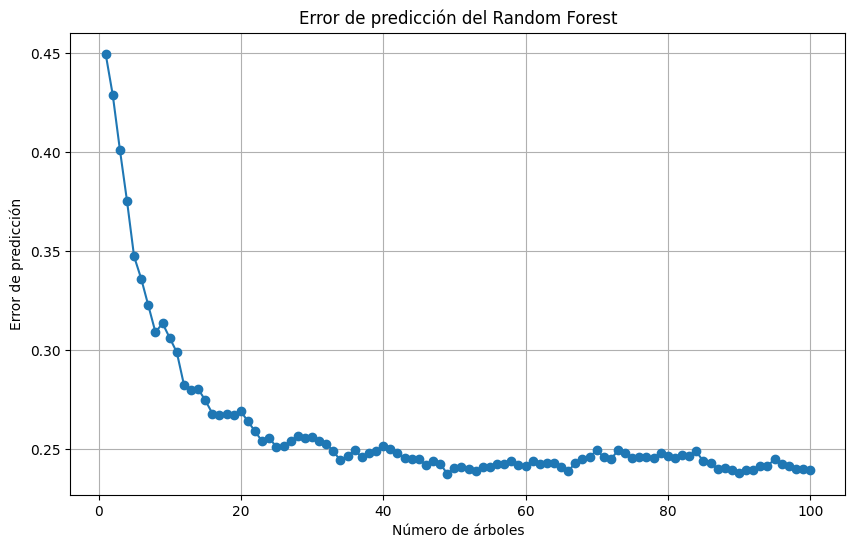

In [ ]:
## CODE 17
# Entrenar el modelo de Random Forest con diferentes números de árboles y calcular el error de predicción
n_trees = 100
errors = []
for i in range(1, n_trees + 1):
    rf = RandomForestClassifier(n_estimators=i, random_state=42)
    rf.fit(X_train, y_train_num)
    error = 1 - rf.score(X_test, y_test_num)
    errors.append(error)


# Graficar el error de predicción en función del número de árboles
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_trees + 1), errors, marker='o', linestyle='-')
plt.xlabel('Número de árboles')
plt.ylabel('Error de predicción')
plt.title('Error de predicción del Random Forest')
plt.grid(True)
plt.show()


RF = RandomForestClassifier(max_depth=20, n_estimators = 200, random_state=0)
RF.fit(X_train, y_train_num)
y_train_pred = RF.predict(X_train)
y_test_pred = RF.predict(X_test)

Feature importances Random forest: [0.16700399 0.07081882 0.13476011 0.07956809 0.09607956 0.10513816
 0.08998369 0.09155693 0.06851339 0.09657725]


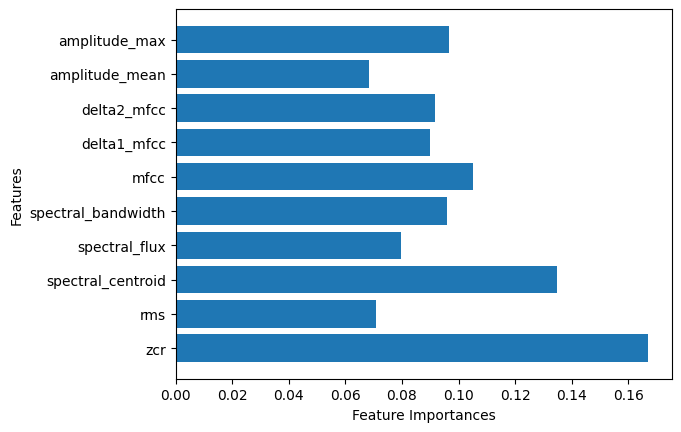

Accuracy - Datos de train: 0.0 
Accuracy - Datos de test: 0.0 


In [ ]:
## CODE 18
# Gráfica de las features
number_of_features = list(range(X_train.shape[1]))
print("Feature importances Random forest:", RF.feature_importances_)
plt.barh(number_of_features, RF.feature_importances_)
plt.yticks(number_of_features, X.columns)
plt.xlabel("Feature Importances")
plt.ylabel("Features")
plt.show()

# Accuracy
print("Accuracy - Datos de train: {} " .format(accuracy_score(y_train, y_train_pred)))
print("Accuracy - Datos de test: {} ". format(accuracy_score(y_test, y_test_pred)))

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Instanciar el LabelEncoder
label_encoder = LabelEncoder()

# Convertir las etiquetas de clase (y_train y y_test) a valores numéricos
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Asegurarse de que y_train_pred y y_test_pred sean de tipo numérico adecuado (int)
y_train_pred = y_train_pred.astype(int)
y_test_pred = y_test_pred.astype(int)

# Verificar tipos de datos después de la conversión
print("Tipo de y_train_encoded:", y_train_encoded.dtype)
print("Tipo de y_test_encoded:", y_test_encoded.dtype)
print("Tipo de y_train_pred:", y_train_pred.dtype)
print("Tipo de y_test_pred:", y_test_pred.dtype)

# Calcular accuracy y visualizar el classification_report
print("Accuracy - Datos de train: {:.2f}".format(accuracy_score(y_train_encoded, y_train_pred)))
print("Accuracy - Datos de test: {:.2f}".format(accuracy_score(y_test_encoded, y_test_pred)))

Tipo de y_train_encoded: int64
Tipo de y_test_encoded: int64
Tipo de y_train_pred: int64
Tipo de y_test_pred: int64
Accuracy - Datos de train: 0.02
Accuracy - Datos de test: 0.03


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


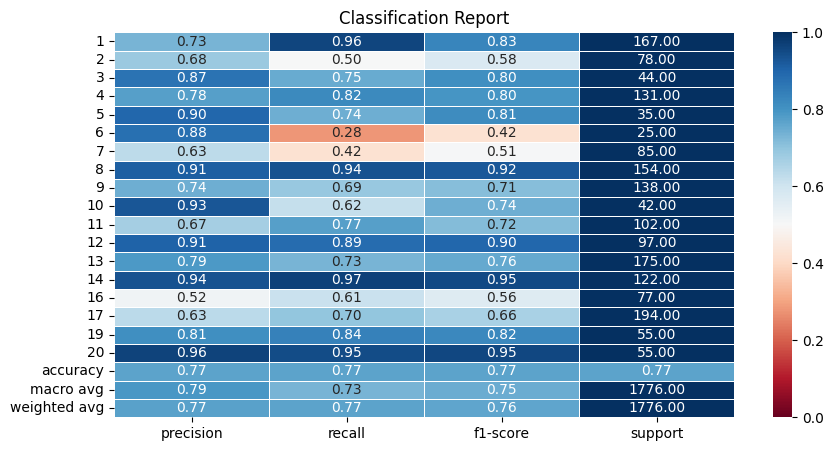

In [ ]:
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Classification report
def visual_classification_report(y_test, y_test_pred):
    report = classification_report(y_test, y_test_pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    plt.figure(figsize=(10, 5))
    sns.heatmap(report_df, annot=True, cmap="RdBu", fmt=".2f", linewidths=.5, vmin=0, vmax=1)
    plt.title('Classification Report')
    plt.show()


visual_classification_report(y_test_num, y_test_pred)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


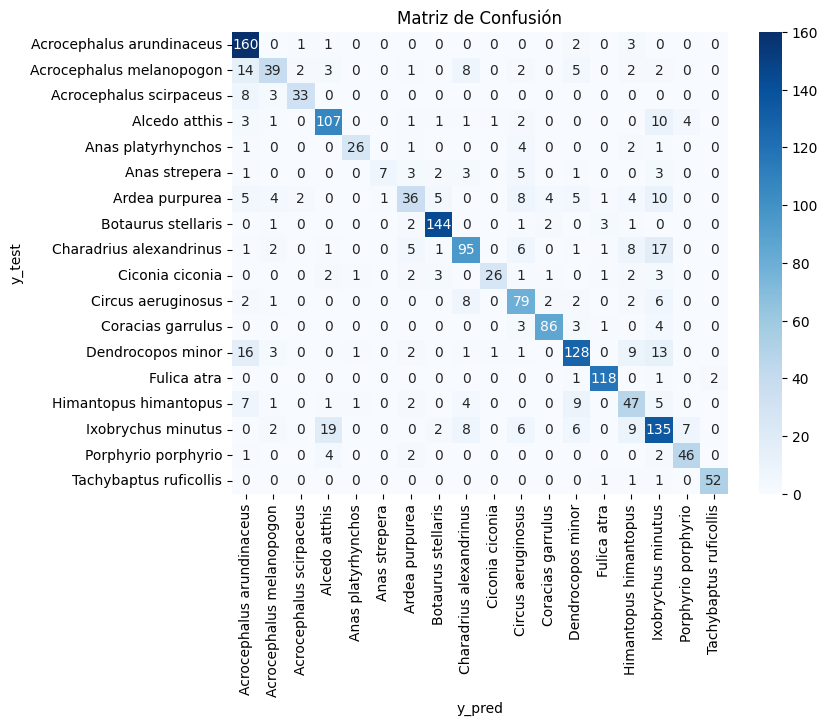

In [ ]:
## CODE 19
# Matriz de confusión
conf_matrix = confusion_matrix(y_test_num, y_test_pred)
classes = np.unique(y_test)


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=classes, yticklabels=classes)
plt.xlabel('y_pred')
plt.ylabel('y_test')
plt.title('Matriz de Confusión')
plt.show()

## RF Repeat - Split por audios

In [5]:
## CODE 15
# Leer datos
main_folder = "/content/drive/MyDrive/BigData/DataMining/Practica1/"
df = pd.read_parquet(os.path.join(main_folder, "df_repetir_ml.parquet"))

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings(action="default")

In [6]:
df.tail(2)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bo

,Directorio,NombreArchivo,audio_file,bird_name,zcr,rms,spectral_centroid,spectral_flux,spectral_bandwidth,mfcc,delta1_mfcc,delta2_mfcc,amplitude_mean,amplitude_max
5719,Motacilla flava,XC102794_2,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5720,Motacilla flava,XC102794_3,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df = df.dropna() # Eliminar filas con NaNs
df.tail(2)

,Directorio,NombreArchivo,audio_file,bird_name,zcr,rms,spectral_centroid,spectral_flux,spectral_bandwidth,mfcc,delta1_mfcc,delta2_mfcc,amplitude_mean,amplitude_max
5070,Porphyrio porphyrio,XC299330_12,XC102794_2.wav,Motacilla flava,0.470248,0.247602,5679.659011,1.761781,909.552667,-28.623531,21.935472,-5.748451,2.066078,14.858106
5071,Porphyrio porphyrio,XC299330_13,XC102794_3.wav,Motacilla flava,0.503577,0.035534,5700.036885,0.031332,1153.708624,-31.346865,24.440853,-6.682345,0.346549,2.522670


In [8]:
# Generamos columna llamada AudioArchivo que nos identifica archivos del mismo audio
df['AudioArchivo'] = df['NombreArchivo'].str.split('_').str[0] # (NombreArchivo antes de la _)
df.tail(2)

,Directorio,NombreArchivo,audio_file,bird_name,zcr,rms,spectral_centroid,spectral_flux,spectral_bandwidth,mfcc,delta1_mfcc,delta2_mfcc,amplitude_mean,amplitude_max,AudioArchivo
5070,Porphyrio porphyrio,XC299330_12,XC102794_2.wav,Motacilla flava,0.470248,0.247602,5679.659011,1.761781,909.552667,-28.623531,21.935472,-5.748451,2.066078,14.858106,XC299330
5071,Porphyrio porphyrio,XC299330_13,XC102794_3.wav,Motacilla flava,0.503577,0.035534,5700.036885,0.031332,1153.708624,-31.346865,24.440853,-6.682345,0.346549,2.522670,XC299330


In [11]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['Directorio', 'bird_name', 'audio_file', 'NombreArchivo', 'AudioArchivo'])
y = df['Directorio']

# Separar los nombres únicos en conjuntos de entrenamiento y prueba
unique_audio_files = df['AudioArchivo'].unique()
train_audio_files, test_audio_files = train_test_split(unique_audio_files, test_size=0.35, random_state=42)

# Crear máscaras para filtrar el DataFrame original
train_mask = df['AudioArchivo'].isin(train_audio_files)
test_mask = df['AudioArchivo'].isin(test_audio_files)

# Crear conjuntos de entrenamiento y prueba
X_train = X[train_mask]
y_train = y[train_mask]
X_test = X[test_mask]
y_test = y[test_mask]

# Verificar la separación
train_size = X_train.shape[0]
test_size = X_test.shape[0]
total_size = df.shape[0]
train_percentage = (train_size / total_size) * 100
test_percentage = (test_size / total_size) * 100

print(f'Tamaño del conjunto de entrenamiento: {train_size} ({train_percentage:.2f}%)')
print(f'Tamaño del conjunto de prueba: {test_size} ({test_percentage:.2f}%)')

Tamaño del conjunto de entrenamiento: 3261 (64.29%)
Tamaño del conjunto de prueba: 1811 (35.71%)


In [ ]:
# Eliminar las columnas 'Directorio' y 'NombreArchivo'
X = df.drop(columns=['Directorio', 'NombreArchivo'])

# Eliminar también las columnas 'NombreBase', 'audio_file' y 'bird_name' si existen
columns_to_drop = ['NombreBase', 'audio_file', 'bird_name']
X = X.drop(columns=columns_to_drop, errors='ignore')

# Definir la variable objetivo y
y = df['Directorio']

# Dividir en conjunto de entrenamiento y prueba (65% train, 35% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=23)

# Verificar las formas de los conjuntos resultantes
print("Shape of X_train:", X_train.shape)
print("X_train:")
print(X_train.head())  # Mostrar solo las primeras filas para verificar

print("\nShape of X_test:", X_test.shape)
print("X_test:")
print(X_test.head())  # Mostrar solo las primeras filas para verificar

Shape of X_train: (3296, 10)
X_train:
           zcr       rms  spectral_centroid  spectral_flux  \
3305  0.159816  0.019972        2362.250839       0.071389   
4574  0.144420  0.005542        2554.723620       0.002390   
2234  0.084240  0.052189        1812.741650       0.232334   
308   0.242315  0.021448        2935.085821       0.023339   
651   0.083663  0.016876        1562.152436       0.015919   

      spectral_bandwidth       mfcc  delta1_mfcc  delta2_mfcc  amplitude_mean  \
3305         1720.105559 -29.641172    21.634809    -6.664005        0.155859   
4574         2376.602992 -33.619560    18.542290    -5.837743        0.067733   
2234         1744.808336  -7.361994    14.638615    -5.749110        0.360982   
308          1435.303827 -50.324467    21.632338    -6.206411        0.125485   
651          1584.086933 -17.335403    12.017095    -4.551982        0.201164   

      amplitude_max  
3305       4.554987  
4574       0.213806  
2234       2.037769  
308        1.5

In [12]:
# Diccionario de mapeo
species_dict = {
    "Acrocephalus arundinaceus": 1,
    "Acrocephalus melanopogon": 2,
    "Acrocephalus scirpaceus": 3,
    "Alcedo atthis": 4,
    "Anas strepera": 5,
    "Anas platyrhynchos": 6,
    "Ardea purpurea": 7,
    "Botaurus stellaris": 8,
    "Charadrius alexandrinus": 9,
    "Ciconia ciconia": 10,
    "Circus aeruginosus": 11,
    "Coracias garrulus": 12,
    "Dendrocopos minor": 13,
    "Fulica atra": 14,
    "Gallinula chloropus": 15,
    "Himantopus himantopus": 16,
    "Ixobrychus minutus": 17,
    "Motacilla flava": 18,
    "Porphyrio porphyrio": 19,
    "Tachybaptus ruficollis": 20}

# Cambiamos los nombres en y por números
y_train_num = np.array([species_dict[species] for species in y_train])
y_test_num = np.array([species_dict[species] for species in y_test])

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


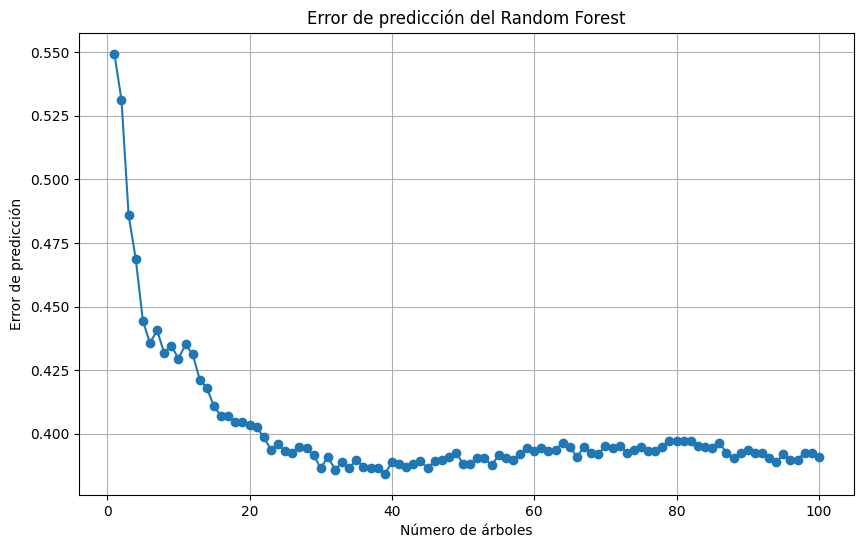

In [13]:
## CODE 17
# Entrenar el modelo de Random Forest con diferentes números de árboles y calcular el error de predicción
n_trees = 100
errors = []
for i in range(1, n_trees + 1):
    rf = RandomForestClassifier(n_estimators=i, random_state=42)
    rf.fit(X_train, y_train_num)
    error = 1 - rf.score(X_test, y_test_num)
    errors.append(error)


# Graficar el error de predicción en función del número de árboles
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_trees + 1), errors, marker='o', linestyle='-')
plt.xlabel('Número de árboles')
plt.ylabel('Error de predicción')
plt.title('Error de predicción del Random Forest')
plt.grid(True)
plt.show()


RF = RandomForestClassifier(max_depth=20, n_estimators = 200, random_state=0)
RF.fit(X_train, y_train_num)
y_train_pred = RF.predict(X_train)
y_test_pred = RF.predict(X_test)

Feature importances Random forest: [0.16146624 0.06683383 0.13411584 0.07135348 0.09273799 0.1149796
 0.09517595 0.09527607 0.06585327 0.10220772]


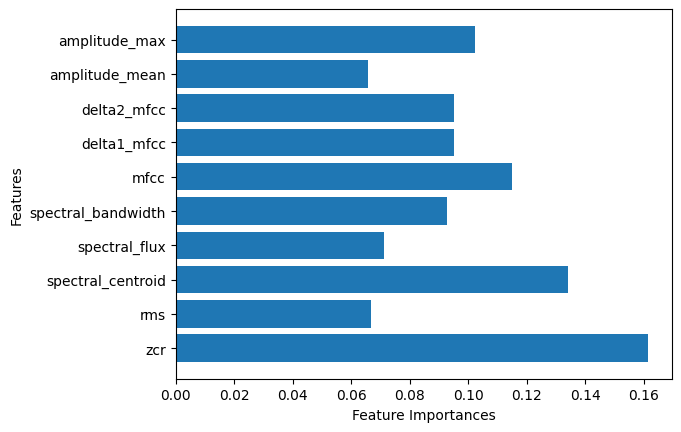

Accuracy - Datos de train: 0.0 
Accuracy - Datos de test: 0.0 


In [14]:
## CODE 18
# Gráfica de las features
number_of_features = list(range(X_train.shape[1]))
print("Feature importances Random forest:", RF.feature_importances_)
plt.barh(number_of_features, RF.feature_importances_)
plt.yticks(number_of_features, X.columns)
plt.xlabel("Feature Importances")
plt.ylabel("Features")
plt.show()

# Accuracy
print("Accuracy - Datos de train: {} " .format(accuracy_score(y_train, y_train_pred)))
print("Accuracy - Datos de test: {} ". format(accuracy_score(y_test, y_test_pred)))

In [15]:
from sklearn.preprocessing import LabelEncoder

# Instanciar el LabelEncoder
label_encoder = LabelEncoder()

# Convertir las etiquetas de clase (y_train y y_test) a valores numéricos
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Asegurarse de que y_train_pred y y_test_pred sean de tipo numérico adecuado (int)
y_train_pred = y_train_pred.astype(int)
y_test_pred = y_test_pred.astype(int)

# Verificar tipos de datos después de la conversión
print("Tipo de y_train_encoded:", y_train_encoded.dtype)
print("Tipo de y_test_encoded:", y_test_encoded.dtype)
print("Tipo de y_train_pred:", y_train_pred.dtype)
print("Tipo de y_test_pred:", y_test_pred.dtype)

# Calcular accuracy y visualizar el classification_report
print("Accuracy - Datos de train: {:.2f}".format(accuracy_score(y_train_encoded, y_train_pred)))
print("Accuracy - Datos de test: {:.2f}".format(accuracy_score(y_test_encoded, y_test_pred)))

Tipo de y_train_encoded: int64
Tipo de y_test_encoded: int64
Tipo de y_train_pred: int64
Tipo de y_test_pred: int64
Accuracy - Datos de train: 0.01
Accuracy - Datos de test: 0.03


<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


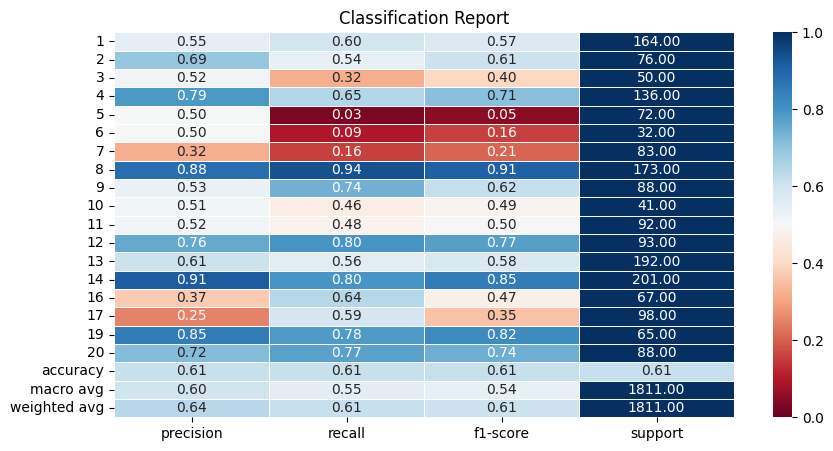

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


In [16]:
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Classification report
def visual_classification_report(y_test, y_test_pred):
    report = classification_report(y_test, y_test_pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    plt.figure(figsize=(10, 5))
    sns.heatmap(report_df, annot=True, cmap="RdBu", fmt=".2f", linewidths=.5, vmin=0, vmax=1)
    plt.title('Classification Report')
    plt.show()


visual_classification_report(y_test_num, y_test_pred)

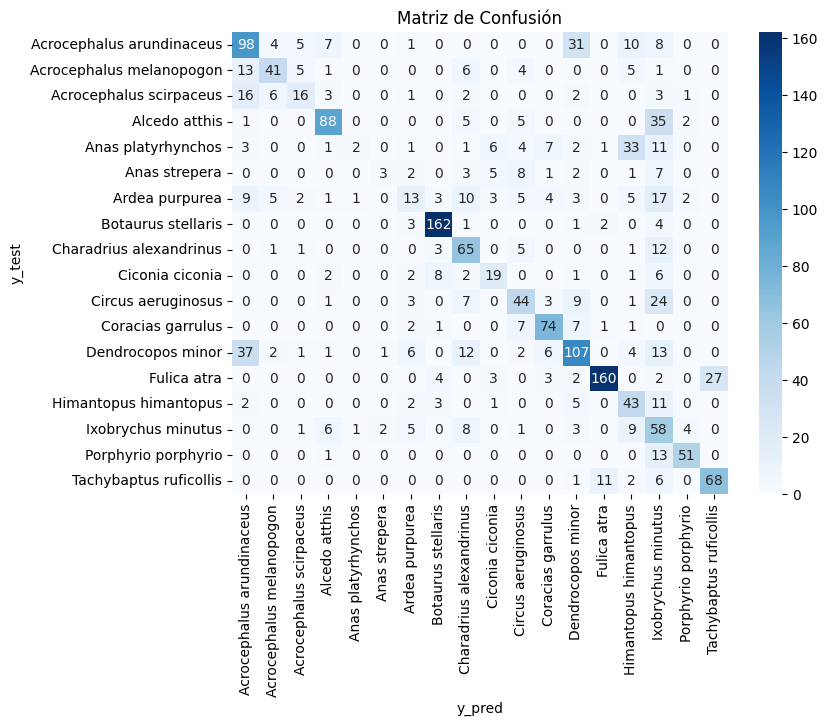

In [17]:
## CODE 19
# Matriz de confusión
conf_matrix = confusion_matrix(y_test_num, y_test_pred)
classes = np.unique(y_test)


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=classes, yticklabels=classes)
plt.xlabel('y_pred')
plt.ylabel('y_test')
plt.title('Matriz de Confusión')
plt.show()